In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




#### Problema a solucionar detallado en https://github.com/SpikeLab-CL/desafio_spike_cuencas

In [247]:
#Helper functions


##Heat map related

def group_data(df, level, variable, fun):
    grouped_by = df.groupby([df.codigo_cuenca,df.codigo_estacion, df.fecha.apply(lambda x: x.year)])[variable]
    grouped_data = getattr(grouped_by, fun)()
    grouped_data = pd.DataFrame(grouped_data)
    grouped_data = grouped_data.rename(columns={variable:"register_"+fun})
    return grouped_data.reset_index()

    
def heatmap_df(df, level, variable, fun,period, codigo_cuenca=None):
 
    grouped_data = group_data(df, level, variable, fun)

    if period == 'decada':
        grouped_data["decada"] = (grouped_data["fecha"]//10)*10
    else:
        period = "fecha"
    columns = ["register_"+fun,"codigo_cuenca",period]
    groupby = ["codigo_cuenca",period]
        
    if level == 'estacion':
        columns.insert(2, "codigo_estacion")
        groupby.insert(1, "codigo_estacion")
        grouped_data = grouped_data[grouped_data['codigo_cuenca']==codigo_cuenca]

    df_heatmap = grouped_data[columns].groupby(groupby).mean()
    df_heatmap = df_heatmap.reset_index()
   
    if level == 'estacion':
        df_heatmap_pivot = df_heatmap.pivot(index="codigo_estacion", columns=period, values="register_"+fun)
    else:
        df_heatmap_pivot = df_heatmap.pivot(index="codigo_cuenca", columns=period, values="register_"+fun)
    return df_heatmap, df_heatmap_pivot



def sort_heatmap_df(df_heatmap_pivot):
    df_heatmap_pivot["mean"]=df_heatmap_pivot.mean(axis=1)
    NA_list =[]
    for i in range(len(df_heatmap_pivot.index)) :
        NA_list.append(df_heatmap_pivot.iloc[i].isnull().sum())
    df_heatmap_pivot["NA_row"] = NA_list
    df_heatmap_pivot = df_heatmap_pivot.sort_values(by=["NA_row","mean"])
    df_heatmap_pivot = df_heatmap_pivot.drop(labels = ["mean","NA_row"], axis=1)
    return df_heatmap_pivot

def create_heatmap(df_heatmap, df_heatmap_pivot,variable, figsize,level,period):
    dict_var = {'caudal' : 'caudal',
                'precip_promedio' : 'precipitación promedio',
                'temp_max_promedio' : 'temperatura máxima promedio',
                'extreme_caudal' : 'caudal extremo',
                'extreme_precip_promedio' : 'precipitación promedio extrema',
                'extreme_temp_max_promedio' : 'temperatura máxima promedio extrema',
                'altura': 'altura'
               } 
    
    
    fig, ax = plt.subplots(figsize=figsize)
    
    plt.yticks(np.arange(0.5, len(df_heatmap_pivot.index), 1), df_heatmap_pivot.index)
    plt.title("Heatmap de mediciones de "+ dict_var[variable] + "por"+ period)
    plt.ylabel(level)
    plt.xlabel(period)
    
    if level == 'estacion':
        plt.title('Heatmap de mediciones de estaciones en cuenca '+str(df_heatmap.codigo_cuenca[0]) + " por "+ period)
    mat = ax.pcolor(df_heatmap_pivot, cmap='YlGn')
    plt.colorbar(mat)
    if period == 'year':
        plt.xticks(np.arange(0.5, len(df_heatmap_pivot.columns), 1),df_heatmap_pivot.columns.to_series().apply(lambda x: str(x)[2:]))

       
    else:
        plt.xticks(np.arange(0.5, len(df_heatmap_pivot.columns), 1),df_heatmap_pivot.columns)

    
    plt.show();
    
    

    
def heatmap_by_period_variable(df,level,variable, fun, period, extreme_var = False, codigo_cuenca=None,order="No", figsize=(30,20)):
    #prep data to feed heat map
    if extreme_var == False:
        df_heatmap , df_heatmap_pivot = heatmap_df(df,level,variable, fun, period, codigo_cuenca)
    else:
        df_heatmap , df_heatmap_pivot = heatmap_extreme_df(df,level, variable, fun)
    #sort rows for clearer visualization
    if order.capitalize()=="Yes":
        df_heatmap_pivot = sort_heatmap_df(df_heatmap_pivot)

    create_heatmap(df_heatmap, df_heatmap_pivot,variable, figsize,level,period)
    
    
    
################################    
## Distribution plot related
################################

def check_date(df, estacion):
    fecha_min = str(df[df['codigo_estacion']==estacion].fecha.min())
    fecha_max = str(df[df['codigo_estacion']==estacion].fecha.max())
    
    return 'Para la estacion '+ str(estacion)+' se tienen datos entre las fechas '+ fecha_min+' y '+fecha_max          


def distribution_plot_station(df, codigo_estacion, var, start_date, end_date):
    
    dict_var = {'caudal' : 'caudal',
                'precip_promedio' : 'precipitación promedio',
                'temp_max_promedio' : 'temperatura máxima promedio'              
                } 
    
    
    data = df[df["codigo_estacion"]==codigo_estacion]
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date  = datetime.strptime(end_date, '%Y-%m-%d').date()
    mask = (df["fecha"] > start_date) & (df["fecha"] <= end_date)
    data = data.loc[mask]
    
    data = data[["fecha", var]]
    
    plt.figure(figsize=(20,10))
    plt.title("Mediciones de "+ dict_var[var] +' para la estación '+str(codigo_estacion)+ " para el periodo "+ check_date(df, codigo_estacion)[-24:])
    plt.xlabel("Años")
    plt.ylabel(dict_var[var].capitalize())
    plt.scatter(data.iloc[:,0], data.iloc[:,1])
    plt.show()

    

    
def distribution_many_col_plot_station(df, codigo_estacion, list_col, start_date, end_date):
    
    dict_var = {'caudal' : 'caudal',
                'precip_promedio' : 'precipitación promedio',
                'temp_max_promedio' : 'temperatura máxima promedio',
                
                } 
    'extreme_caudal','extreme_precip_promedio','extreme_temp_max_promedio'
    
    data = df[df["codigo_estacion"]==codigo_estacion]
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date  = datetime.strptime(end_date, '%Y-%m-%d').date()
    mask = (df["fecha"] > start_date) & (df["fecha"] <= end_date)
    data = data.loc[mask]
    data.reset_index(inplace = True)
    
    if df[df['codigo_estacion']==codigo_estacion].fecha.min() > start_date:
       
        print("Fecha fuera de rango. "+check_date(df, codigo_estacion) )
    
    else:
        
        try:#normalization
            scaler = preprocessing.StandardScaler()
            scaled_df = scaler.fit_transform(data[list_col])
            scaled_df = pd.DataFrame(scaled_df, columns=list_col)
            scaled_df.insert(loc=0, column="fecha", value= data["fecha"])
            scaled_df = scaled_df.sort_values(by='fecha')
            plt.figure(figsize=(20,10))
            for i in range(0,len(list_col)):
                plt.scatter(scaled_df.iloc[:,0], scaled_df.iloc[:,i+1])
                plt.plot(scaled_df.iloc[:,0], scaled_df.iloc[:,i+1], label=scaled_df.columns[i+1])
            plt.xlabel("Años")
            plt.ylabel("Eje normalizado con StandardScaler")
            plt.legend()

            if len(list_col)>2:
                ', '.join([dict_var[var] for var in list_col[:-1]])+', and'+ list_col[-1]
            elif len(list_col) ==2:
                ' and '.join([dict_var[var] for var in list_col])
            else:
                var_strings = [dict_var[var] for var in list_col]
            var_strings = ' '.join([dict_var[var] for var in list_col])

            var_strings = ''.join([dict_var[var] for var in list_col])
            plt.title("Medición de "+var_strings +" en estación "+ str(codigo_estacion)+" entre el periodo "+ str(start_date)+ " y " + str(end_date) )
            plt.show()
        
        except:
                print("No hay datos en ese periodo, intente ampliando el rango dentro de "+ check_date(df, codigo_estacion)[-24:])
    

    
    
################################    
## Extreme variable related
################################


    
##### Extreme event categotization
def extreme_value_variable(df,variables):
    # diccionario para asignar estación
    lookup_season = {        
        1: 'Verano',
        2: 'Verano',
        3: 'Verano',
        4: 'Otono',
        5: 'Otono',
        6: 'Otono',
        7: 'Invierno',
        8: 'Invierno',
        9: 'Invierno',
        10: 'Primavera',
        11: 'Primavera',
        12: 'Primavera',
        }
    local_df = df.copy(deep=True)
    for variable in variables:
        local_df['season'] = local_df.fecha.apply(lambda x: lookup_season[x.month])
        local_df['estacion_season'] = list(zip(local_df['codigo_estacion'],local_df['season']))
        df_quantile_dict = local_df[['codigo_estacion','season',variable]].groupby(
                             ['codigo_estacion','season']).quantile(.95).apply(list).to_dict()[variable]

        local_df[variable+'_95']  = local_df['estacion_season'].map(df_quantile_dict)
        local_df['extreme_'+variable] = np.multiply(local_df[variable]> local_df[variable+"_95"],1)
        local_df = local_df.drop(columns=['estacion_season',variable+'_95'])
    return local_df


def plot_extreme_var_year(df, var, figsize):
        dict_var = {'extreme_caudal' : 'caudal extremo',
                   'extreme_precip_promedio' : 'precipitación promedio extrema',
                   'extreme_temp_max_promedio' : 'temperatura máxima promedio extrema',
                   }        
      
        df_ext_year = df.groupby([df.fecha.apply(lambda x: x.year)])[var].mean()
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(df_ext_year.index, df_ext_year.multiply(100),  align='center', alpha=0.5, ecolor='black', capsize=10)
        plt.title("Porcentaje de ocurrencia de "+dict_var[var]+" por año para todas las estaciones")
        plt.xlabel('Años')
        plt.ylabel('Porcentaje de eventos de '+dict_var[var])
        plt.show()    

def plot_extreme_var_year_per_station(df, var, estacion, figsize):
        dict_var = {'extreme_caudal' : 'caudal extremo',
                   'extreme_precip_promedio' : 'precipitación promedio extrema',
                   'extreme_temp_max_promedio' : 'temperatura máxima promedio extrema',
                   }        
      
        
        df_ext_year = df.groupby([df.codigo_estacion, df.fecha.apply(lambda x: x.year)])[var].mean()

        df_ext_estacion = df_ext_year[estacion]
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(df_ext_estacion.index, df_ext_estacion.multiply(100),  align='center', alpha=0.5, ecolor='black', capsize=10)
        plt.title("Porcentaje de ocurrencia de "+dict_var[var]+" por año para estación "+str(estacion))
        plt.xlabel('Años')
        plt.ylabel('Porcentaje de eventos de '+dict_var[var])
        plt.show()
        plt.show()        
    
    
#################
#### Modeling related
#################

def get_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window=365).mean()
    rolling_std = timeseries.rolling(window=365).std()
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['caudal'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## Exploracion de los datos

In [4]:
df = pd.read_csv('/Users/nisum/Documents/Analytics/ml/spike/data/caudal_extra.csv')

## **2** ¿Qué puedes decir de los datos? distribuciones, missings y otros?
hay algo que te llame la atencion? porque hay tantos valores missing? Hint: pensar en cómo se elaboró el data set.

In [5]:
# checking for duplicated data
df.duplicated().value_counts()

False    1411180
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411180 entries, 0 to 1411179
Data columns (total 17 columns):
Unnamed: 0                1411180 non-null int64
codigo_estacion           1411180 non-null int64
institucion               1411180 non-null object
fuente                    1411180 non-null object
nombre                    1411180 non-null object
altura                    1411180 non-null int64
latitud                   1411180 non-null float64
longitud                  1411180 non-null float64
codigo_cuenca             1411180 non-null int64
nombre_sub_cuenca         1411180 non-null object
cantidad_observaciones    1411180 non-null int64
fecha                     1411180 non-null object
caudal                    1411180 non-null float64
gauge_id                  1411180 non-null int64
gauge_name                1411180 non-null object
precip_promedio           1383413 non-null float64
temp_max_promedio         1259617 non-null float64
dtypes: float64(5), int64(6), object(6

In [7]:
df["fecha"] =  pd.to_datetime(df["fecha"], format="%Y-%m-%d %H:%M:%S")
df["fecha"] = df["fecha"].dt.date

In [8]:
# Period of data set
print(df.fecha.nunique()/365)
print(max(df.fecha))
print(min(df.fecha))

58.224657534246575
2018-03-09
1960-01-02


In [9]:
#number of river basin
print("Número de cuencas: {}".format(len(df.codigo_cuenca.unique())))
#number of stations
print("Número de estaciones: {}".format(len(df.codigo_estacion.unique())))

Número de cuencas: 29
Número de estaciones: 133


In [10]:
#number of station per river basin
df.groupby(df["codigo_cuenca"])["codigo_estacion"].nunique().sort_values(ascending= False)

codigo_cuenca
83     15
73     11
21      8
45      8
57      8
113     7
32      7
38      7
47      7
34      6
81      6
43      5
115     4
91      4
54      4
60      3
10      3
122     3
111     3
71      2
94      2
103     2
117     2
52      1
104     1
107     1
110     1
12      1
128     1
Name: codigo_estacion, dtype: int64

In [11]:
df[['caudal','precip_promedio', 'temp_max_promedio','altura']].describe()

,caudal,precip_promedio,temp_max_promedio,altura
count,1.411180e+06,1.383413e+06,1.259617e+06,1.411180e+06
mean,9.552229e+01,1.921009e+00,1.921110e+01,5.855691e+02
std,2.526337e+02,7.361936e+00,7.307081e+00,8.652682e+02
min,0.000000e+00,0.000000e+00,-1.905000e+01,0.000000e+00
25%,1.250000e+00,0.000000e+00,1.370000e+01,4.500000e+01
50%,8.950000e+00,0.000000e+00,1.908429e+01,3.950000e+02
75%,6.970000e+01,0.000000e+00,2.520000e+01,7.500000e+02
max,1.580500e+04,2.586000e+02,4.150000e+01,4.370000e+03


Se creó la funcion heatmap_by_period_variable se puede explorar visualmente los datos a nivel de cuenca o estaciones por cuenca, por años y por décadas.
Par auna mejor visualización y posterior análisis se hará una normalización de los datos definiendo una media de 0 y desviación estandar de 1

In [12]:
list_scal = ['caudal','precip_promedio','temp_max_promedio', 'altura']

scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df[list_scal])
df_scaled = pd.DataFrame(df_scaled, columns=list_scal)
df_scaled= pd.concat([df[['codigo_estacion','codigo_cuenca','fecha']], df_scaled], axis=1)

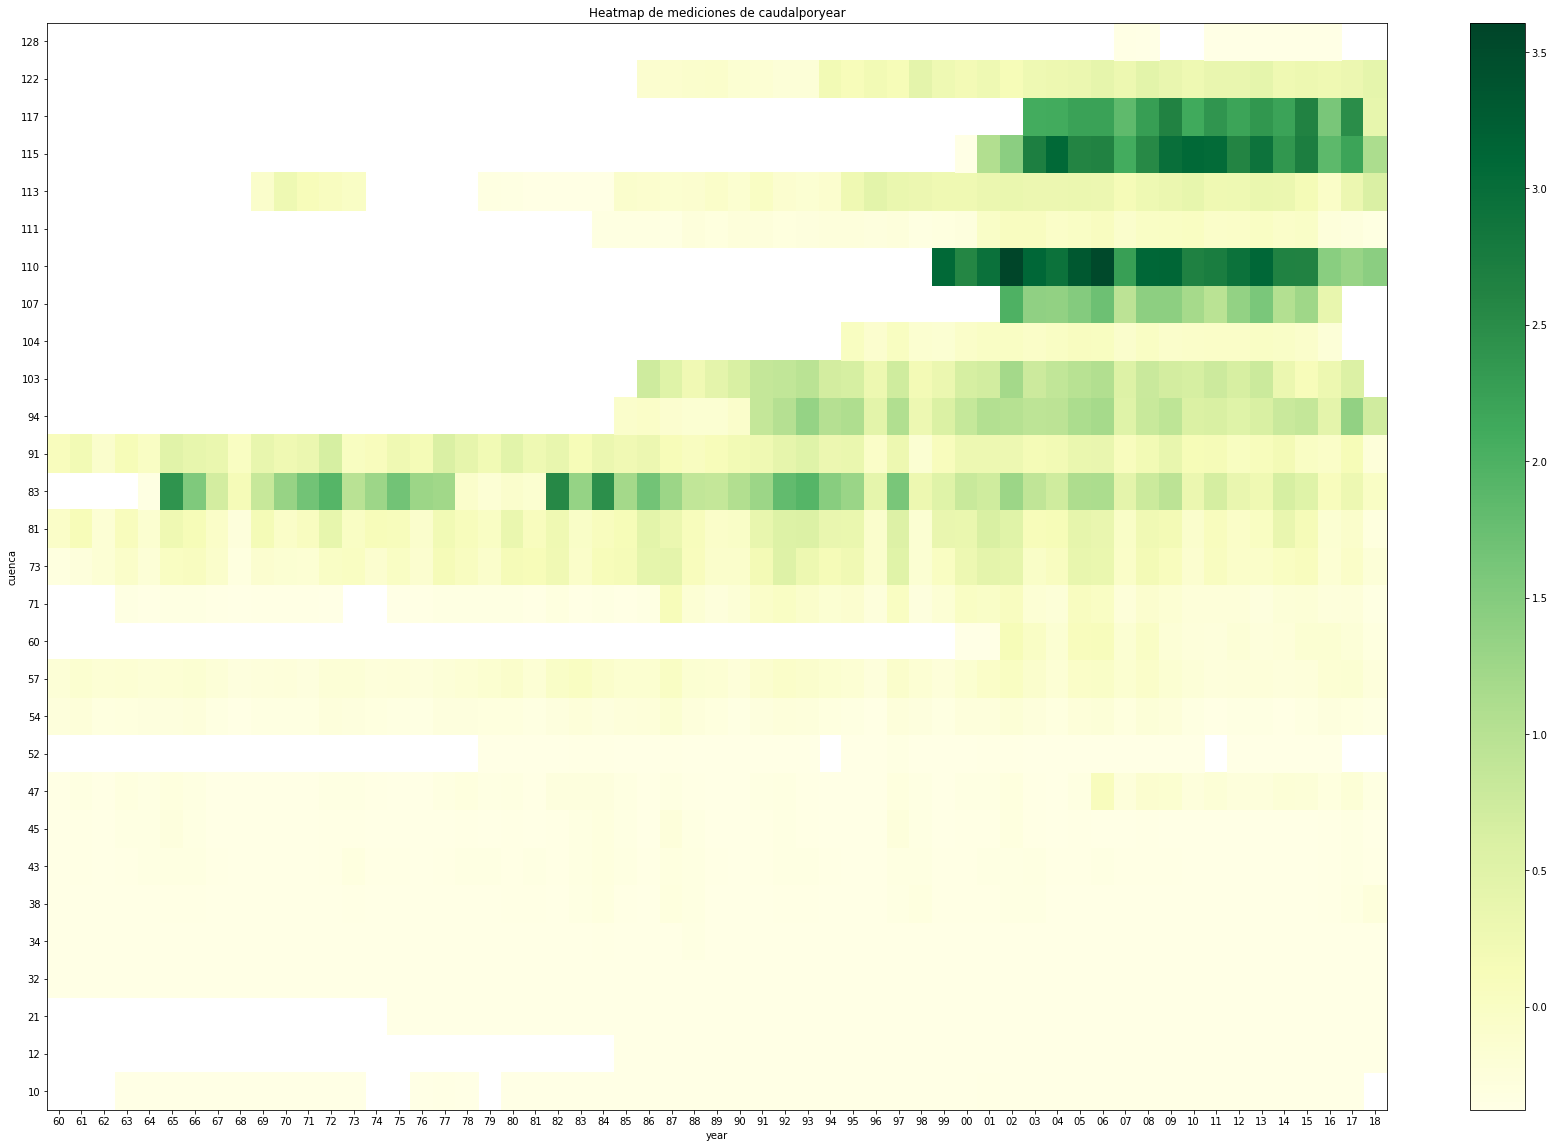

In [14]:
heatmap_by_period_variable(df_scaled,'cuenca','caudal', 'mean','year')

Al observar el heatmap se tiene que la gran mayoria presenta valores similares de caudal a lo largo de los años, a excepción de unas cuencas, a saber: 117,115,110,107,103, 94,83.
Al visualizar la ubicación de estar cuencas, se observa que se encuentran en la zona sur del país. 

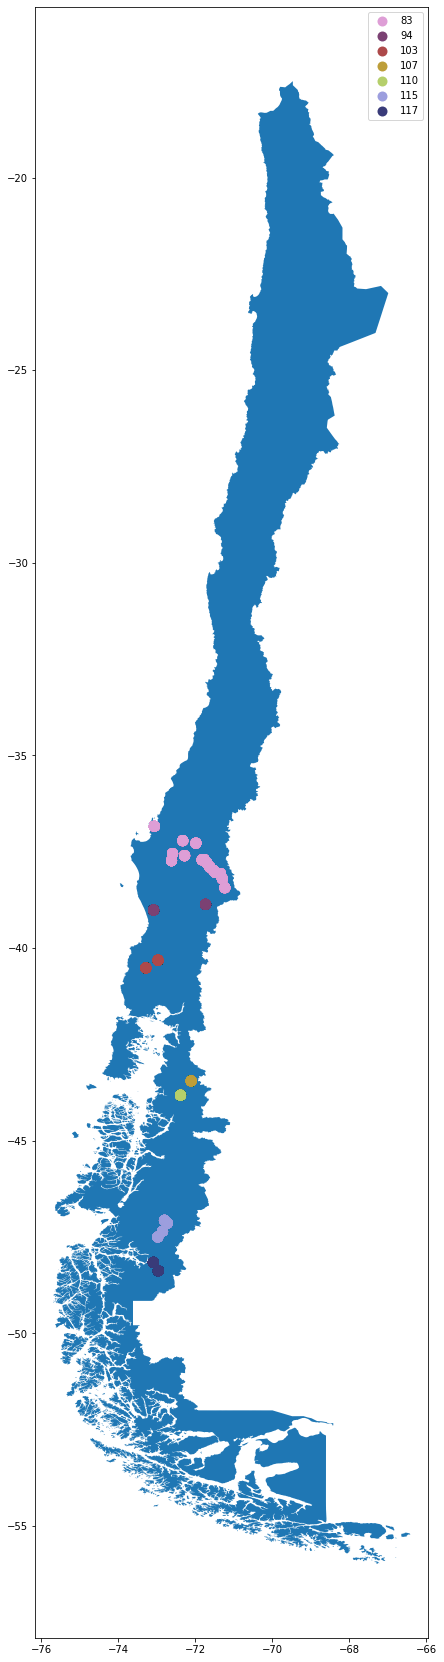

In [241]:
# mapa de http://labgeo.ufro.cl/fichas/chile_geo/ficha_cl_geo.html 
map_= gpd.read_file("/Users/nisum/Downloads/cl_continental_geo/cl_continental_geo.shp")

df_geom = df[["codigo_cuenca","codigo_estacion","latitud","longitud" ]]

geometry =[Point(xy) for xy in zip( df_geom["longitud"],df_geom["latitud"])]
geo_df =gpd.GeoDataFrame(df_geom,
                        crs={"init":"epsg:4326"},
                        geometry= geometry) 

geo_df_1 =geo_df[geo_df.codigo_cuenca.isin([117,115,110,107,103, 94,83])]
ax = map_.plot(figsize=(40, 30))
geo_df_1.plot(ax=ax, marker='o', column='codigo_cuenca', categorical=True,  markersize=100, legend=True, cmap='tab20b_r') 

Considerando la relación que se tiene con el aumento de los caudales y el agua proveniente de los deshielo, se exploró superficialmente la relación que podría existir entre los valores de altura y los promedios de caudal por año para la cuenca 83.

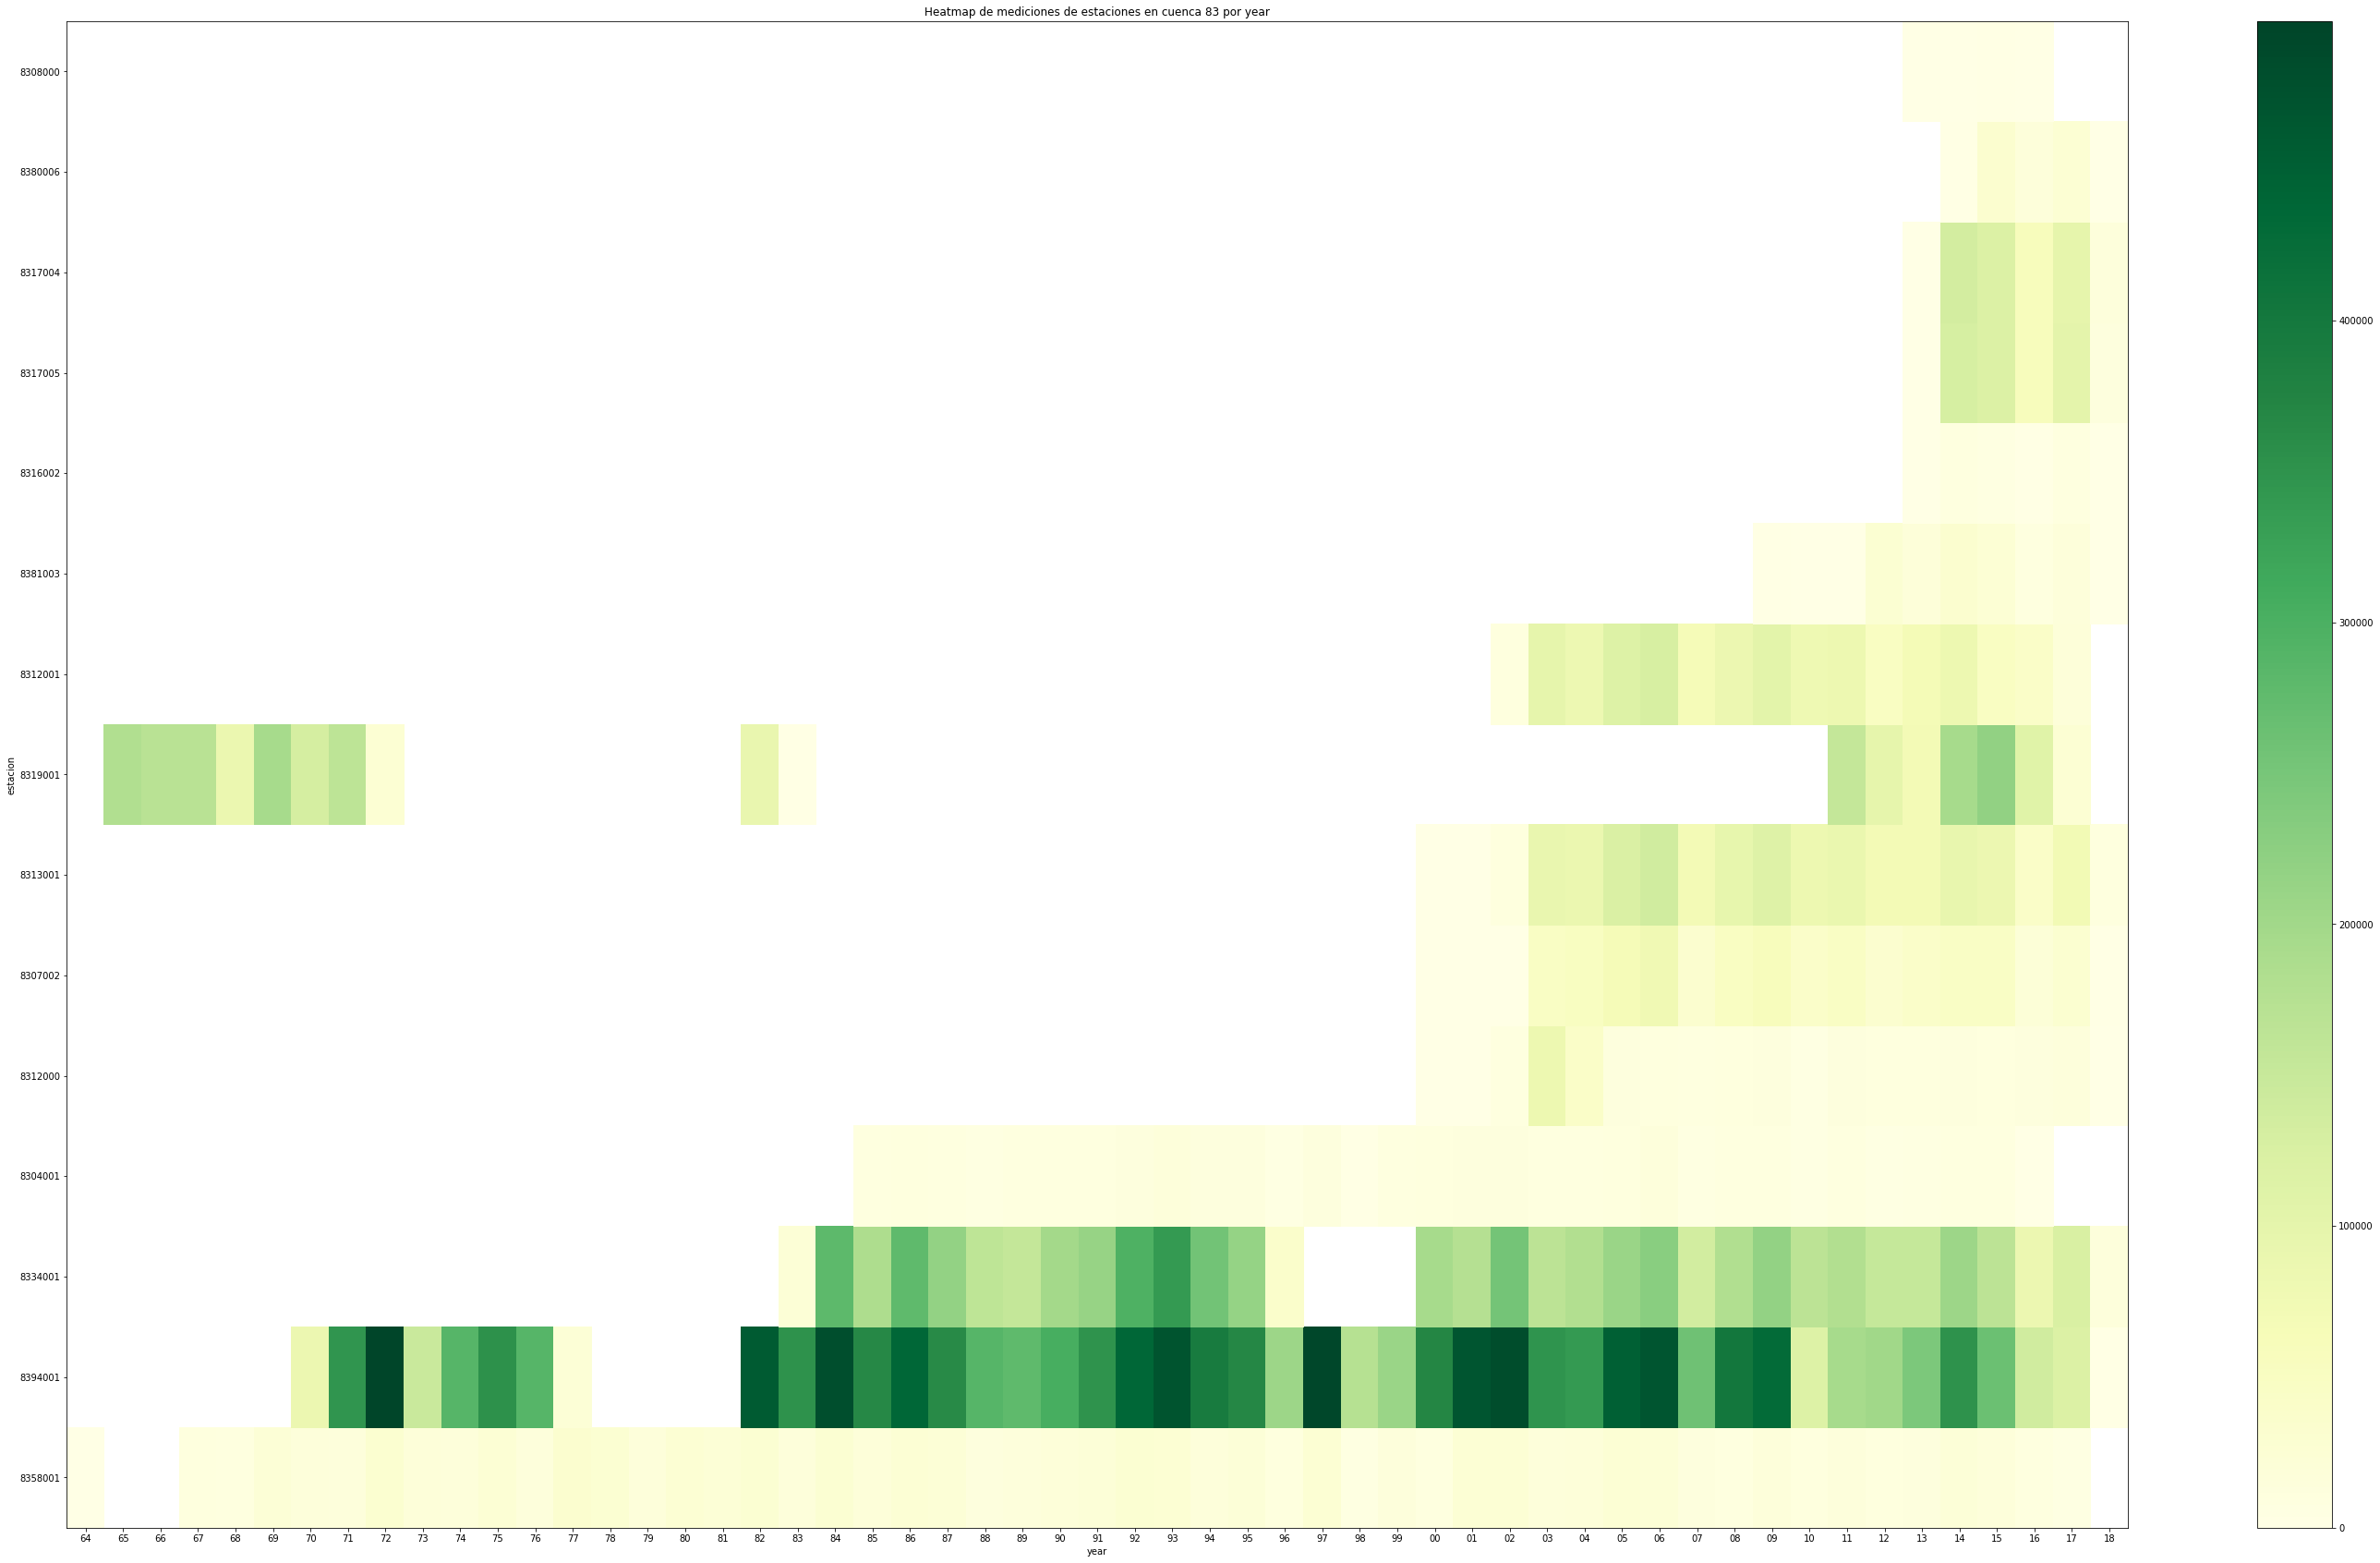

In [261]:
heatmap_by_period_variable(df,level="estacion",variable="caudal", fun="sum", period="year",codigo_cuenca=83, order="yes",figsize=(50,30))

In [258]:
df_altura = df[["codigo_cuenca","caudal","codigo_estacion","altura", "fecha"]]
df_altura_=df_altura[df_altura.codigo_cuenca.isin([117,115,110,107,103, 94,83])].drop_duplicates()

In [249]:
df_altura_plot = df_altura[df_altura.codigo_cuenca.isin([117,115,110,107,103, 94,83])].drop_duplicates(subset="codigo_estacion").sort_values(by=["codigo_cuenca","altura"])

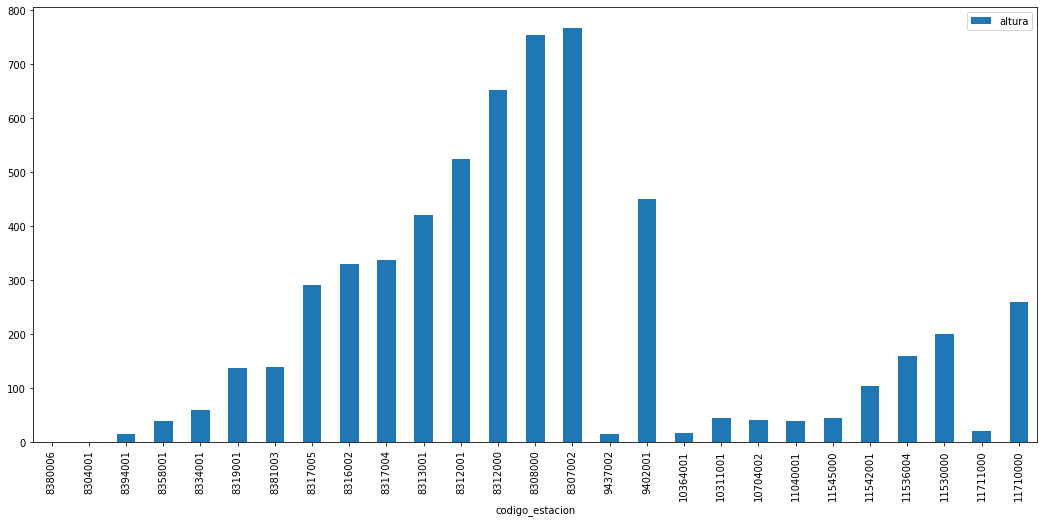

In [250]:
df_altura_plot.plot.bar(x="codigo_estacion",y="altura")

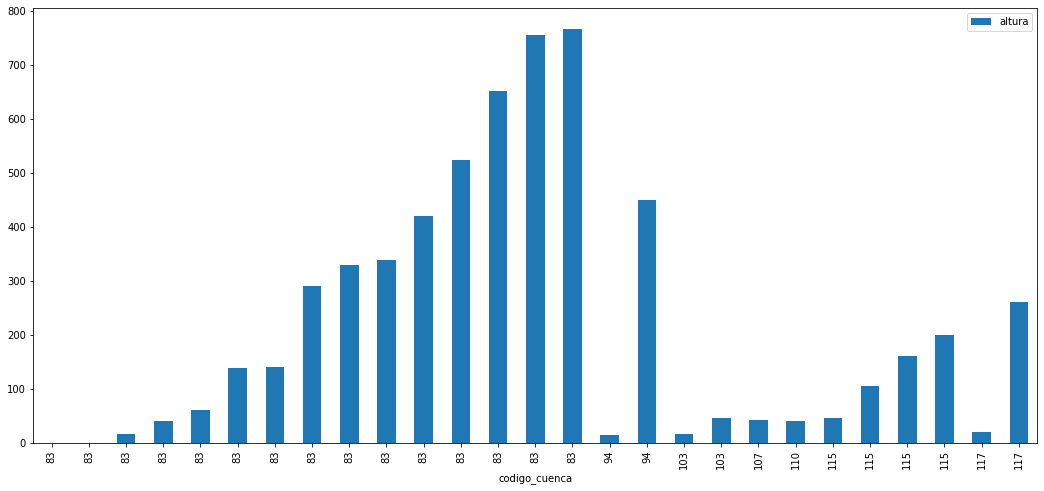

In [251]:
df_altura_plot.plot.bar(x="codigo_cuenca",y="altura")

(lo repetí para ver los números de cuenca, dado que no tuve tiempo de hace un eje jerarquizado)

In [256]:
df_caudal_year_83,_= heatmap_df(df_altura_ , "estacion", "caudal","mean","year", 83)
df_caudal_altura_83,_= heatmap_df(df_altura_ , "estacion", "altura","mean","year", 83)

In [257]:
np.corrcoef(df_caudal_year_83.groupby(by=["codigo_estacion"]).mean()["register_mean"], df_caudal_altura_83.groupby(by=["codigo_estacion"]).mean()["register_mean"])

array([[ 1.        , -0.35243115],
       [-0.35243115,  1.        ]])

Se realizó esto con la intensión de explorar un poco la relación entre las variables. Es interesante observar desde los dataframes que dentro de una misma cuenca, se pueden tener mediciones de similar altura y muy diferente promedio. Podría ser de utilidad explorar más allá la geografía y las conexiones con otros rios que podrían estar alimentando los caudales. 


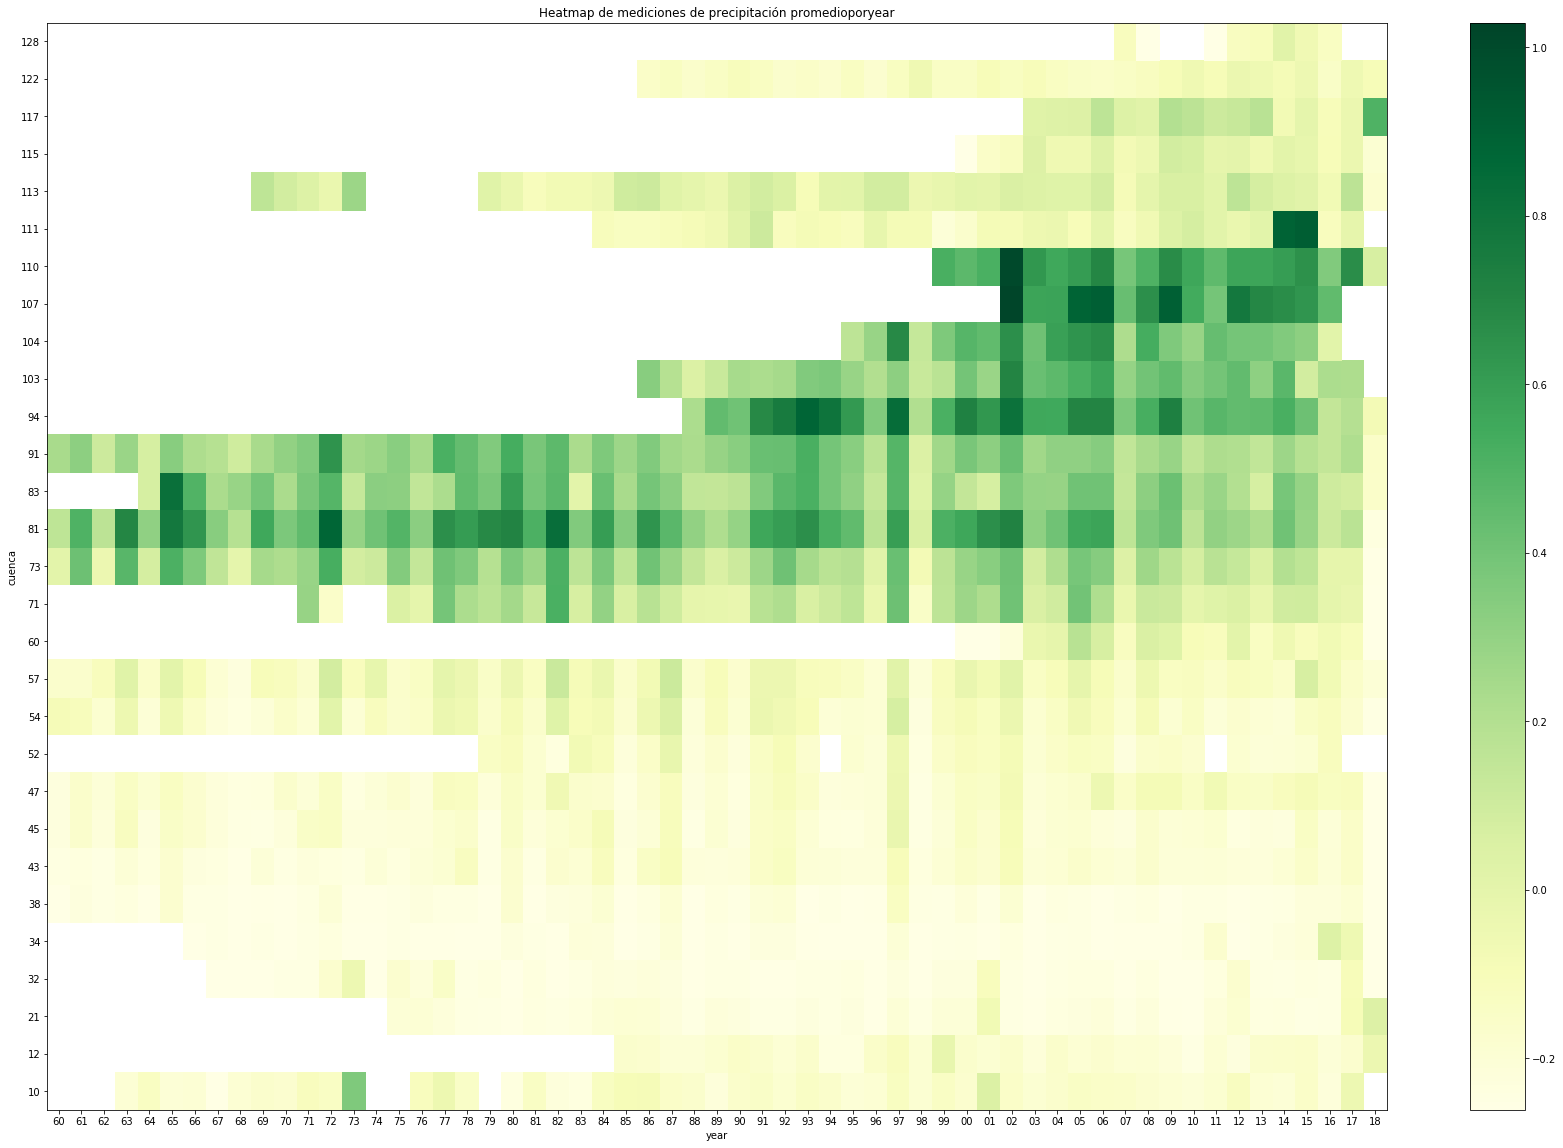

In [15]:
heatmap_by_period_variable(df_scaled,'cuenca','precip_promedio', 'mean','year')

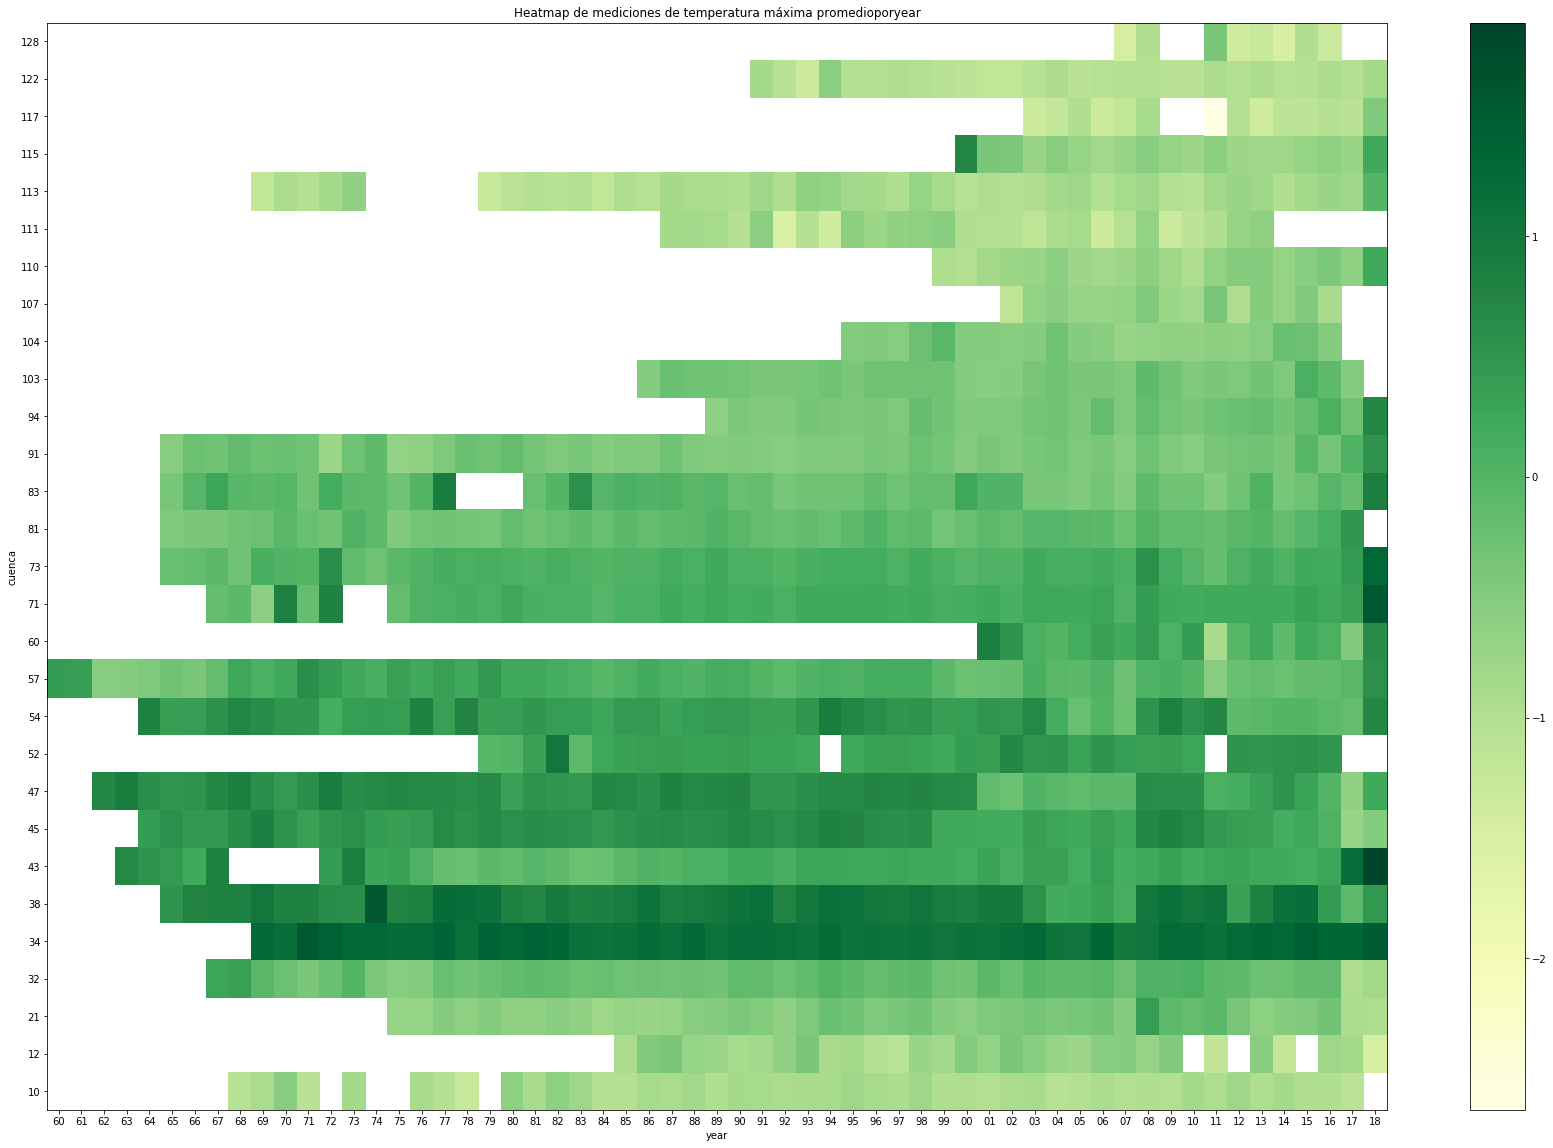

In [16]:
heatmap_by_period_variable(df_scaled,'cuenca','temp_max_promedio', 'mean','year')

In [17]:
df[['caudal','precip_promedio','temp_max_promedio' ]].corr()

,caudal,precip_promedio,temp_max_promedio
caudal,1.000000,0.191504,-0.233441
precip_promedio,0.191504,1.000000,-0.259801
temp_max_promedio,-0.233441,-0.259801,1.000000


#### Revisión de missing values:

In [18]:
df.isna().sum()

Unnamed: 0                     0
codigo_estacion                0
institucion                    0
fuente                         0
nombre                         0
altura                         0
latitud                        0
longitud                       0
codigo_cuenca                  0
nombre_sub_cuenca              0
cantidad_observaciones         0
fecha                          0
caudal                         0
gauge_id                       0
gauge_name                     0
precip_promedio            27767
temp_max_promedio         151563
dtype: int64

In [19]:
#checkeo de missing data por periodos.
null_data_rain = df[df["precip_promedio"].isnull()]
null_data_avg_temp = df[df["temp_max_promedio"].isnull()]

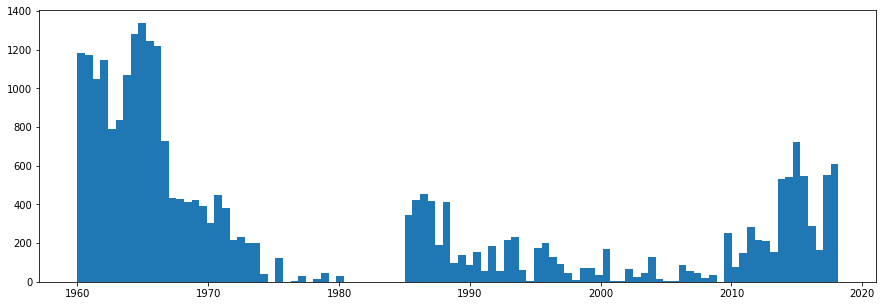

In [20]:
plt.figure(figsize=(15,5))
plt.hist(null_data_rain["fecha"], bins=100);

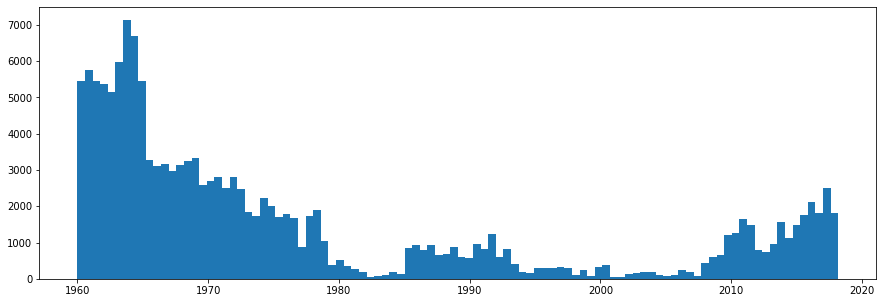

In [21]:
plt.figure(figsize=(15,5))
plt.hist(null_data_avg_temp["fecha"], bins=100);

Respecto a los missing values, estos se encuentran presentes en las variables asociadas a la precipitación promedio y a la temperatura máxima promedio. Una de las causas por la que se podría dar esta situación es la manera en la que se armó el data set en el que se trazaron áreas con estaciones de medición de caudal, pero en las cuales no necesariamente habían estaciones de medición de precipitaciones o tempratura.
Al analizar los histogramas de los missing values, se puede pensar en ausencia de centros o creación de nuevos centros en otros lugares cambiandose de área, razones políticas, etc. 

Respecto a la distribución de los datos que se visualizará a continuación
se observa que la temperatura como era de esperar presenta una fuerte *seasonality*, cosa 
que se logró observar para el caudal pero no en todas las estaciones inspeccionadas.
De la variable de precipitación llama la atención la alta frecuencia de valores 0. 


## **3.a** Plots de precipitación, temperatura y caudal
 a)Escribir fn que tome input una estacion y haga plot para una columna. 

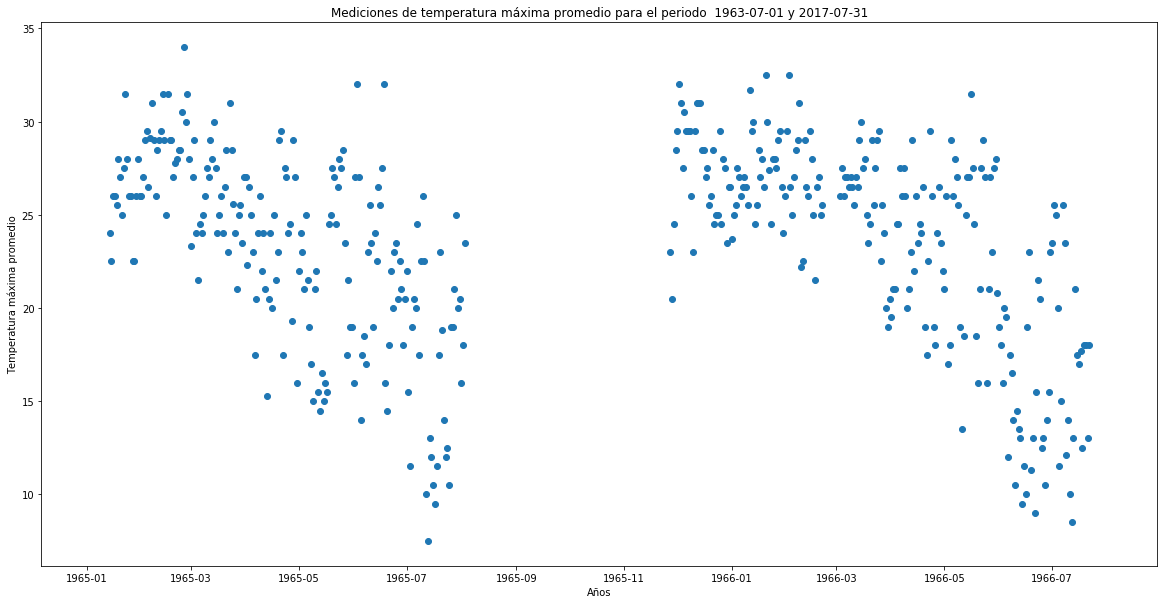

In [22]:
distribution_plot_station(df,4537001, "temp_max_promedio", "1960-01-06", "1966-07-22"  )

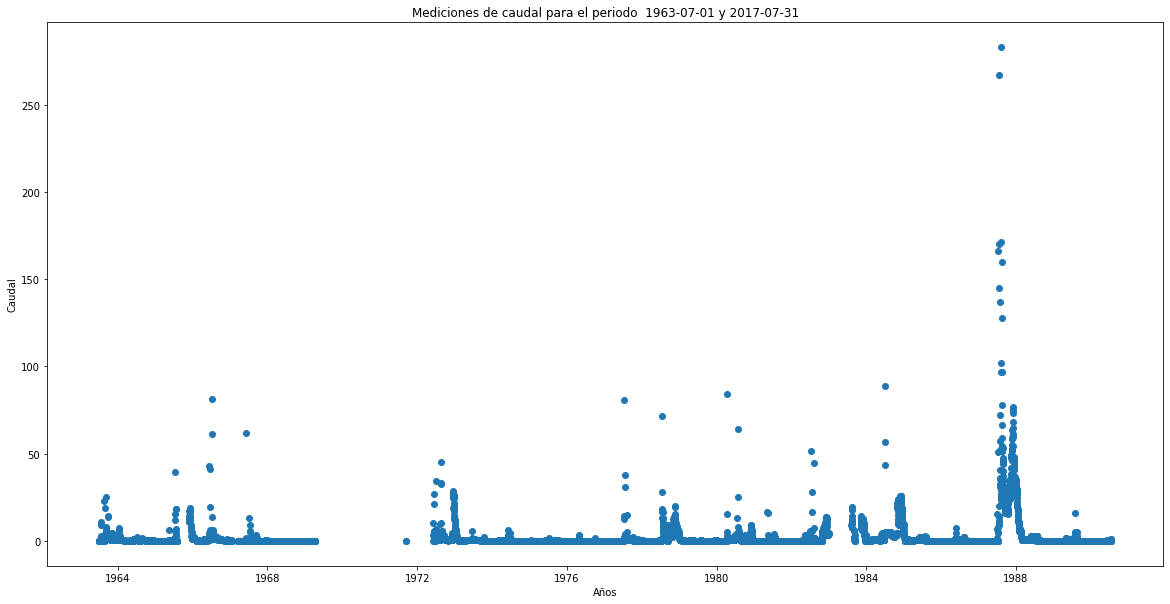

In [23]:
distribution_plot_station(df,4537001, "caudal", "1960-01-06", "1990-07-22"  )

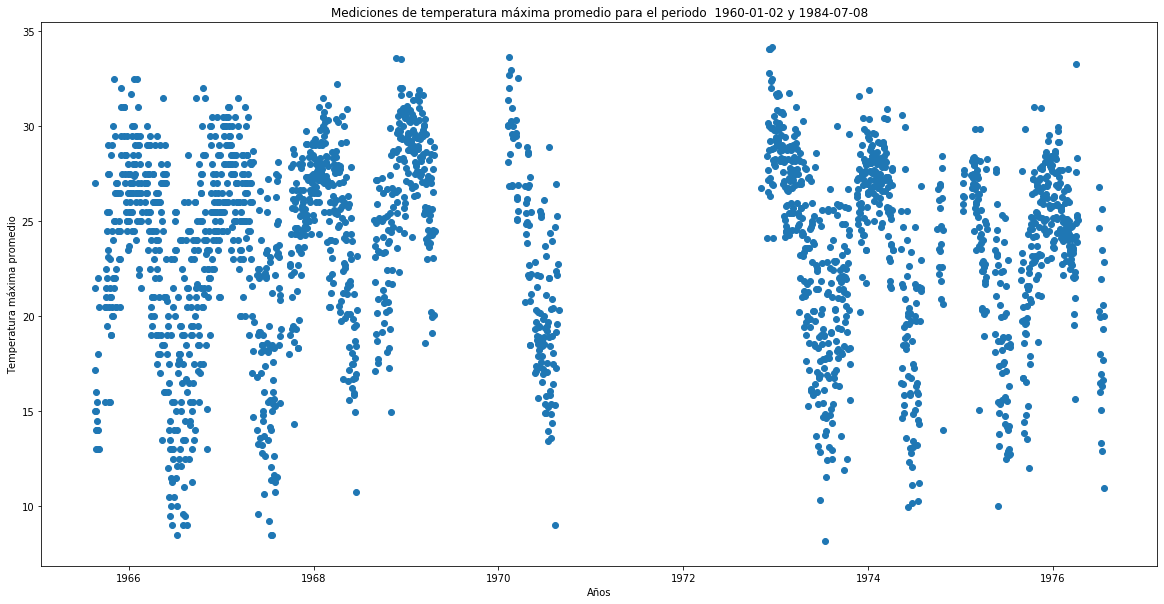

In [24]:
distribution_plot_station(df,4540001, "temp_max_promedio", "1960-01-06", "1976-07-22"  )

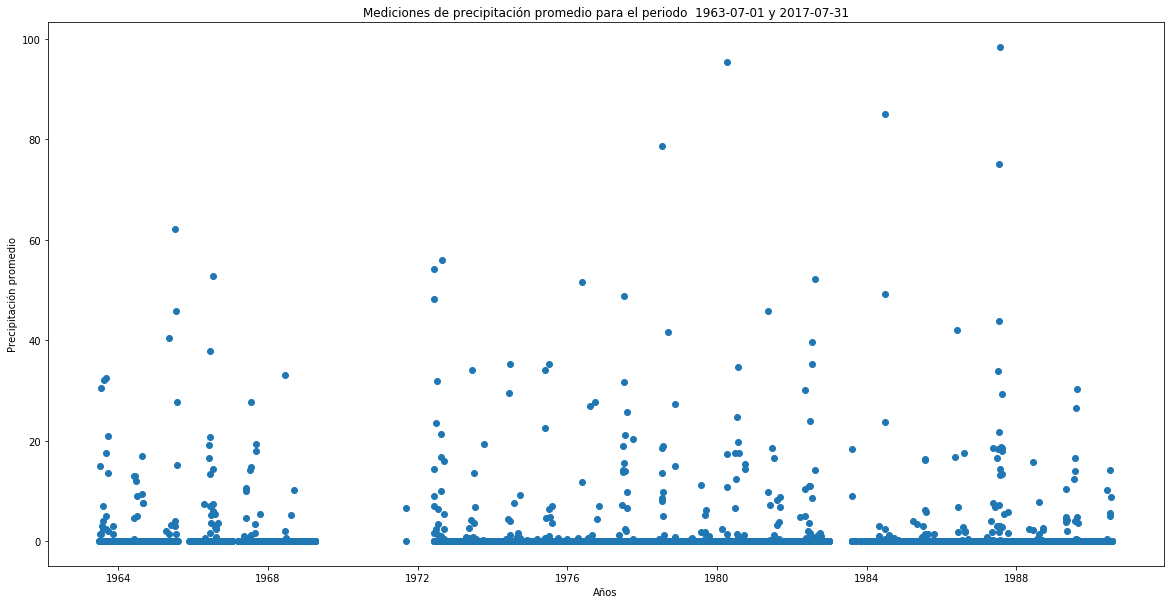

In [25]:
distribution_plot_station(df,4537001, "precip_promedio", "1960-01-06", "1990-07-22"  )

## **3.b** Plots de precipitación, temperatura y caudal
 b) funcion que haga plots de varias columnas
 tips: normalizar las series.

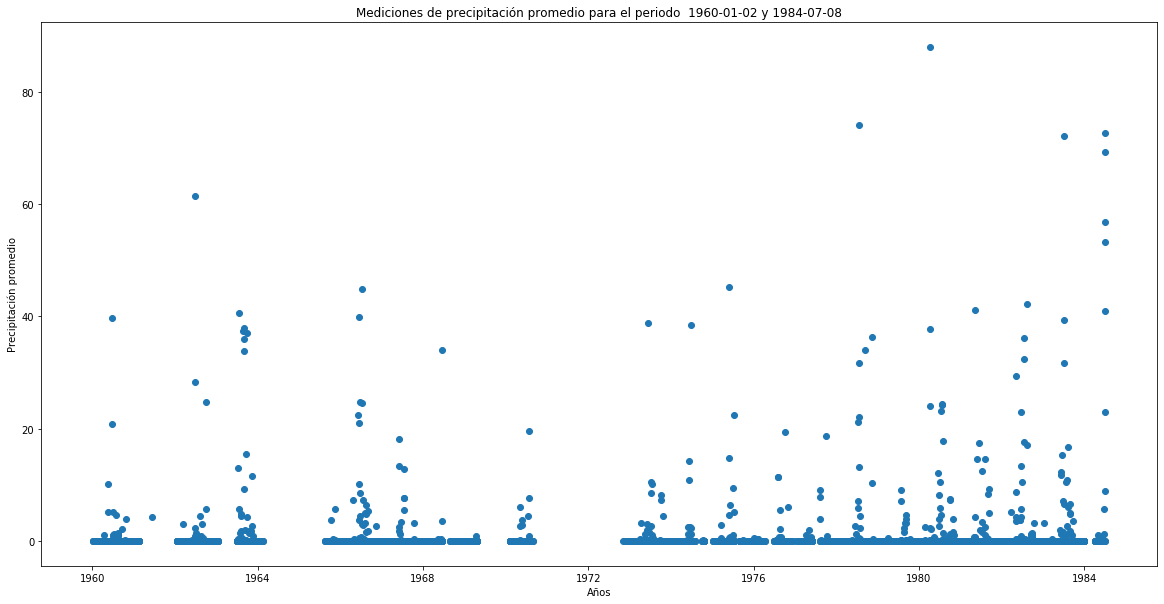

In [26]:
distribution_plot_station(df,4540001, "precip_promedio", "1960-01-06", "2017-07-22"  )

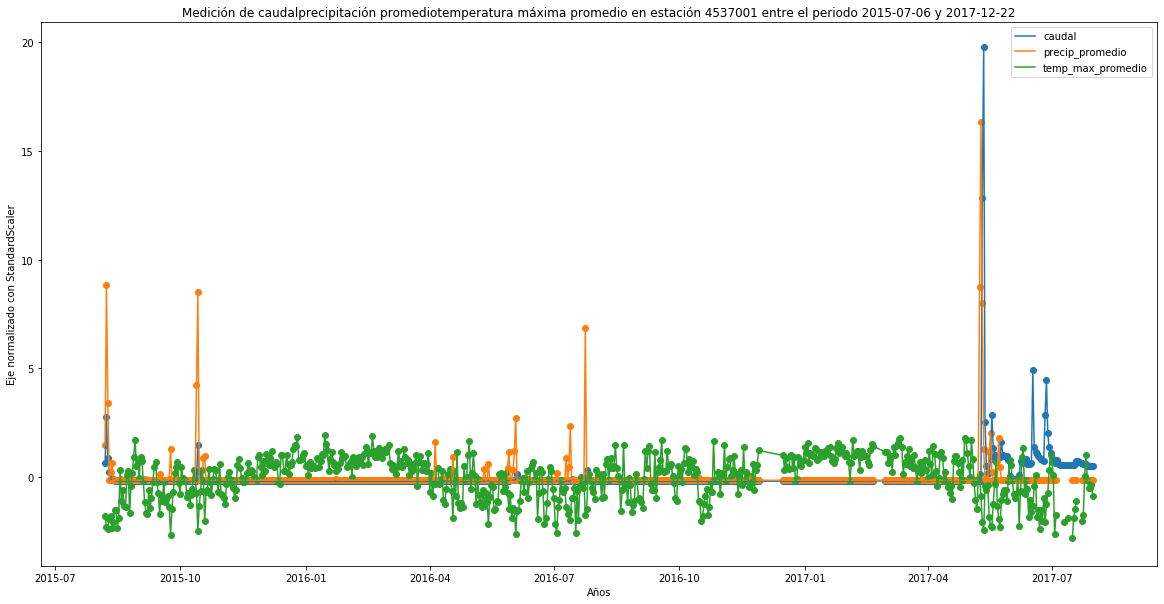

In [27]:
distribution_many_col_plot_station(df,4537001, ["caudal",'precip_promedio', "temp_max_promedio"], "2015-07-06", "2017-12-22" )

## **4** Variables con valores extremos

In [30]:
extreme_variables_list = ['caudal','precip_promedio', "temp_max_promedio"]
df_extreme_var = extreme_value_variable(df_scaled,extreme_variables_list)

In [31]:
print(df_extreme_var['extreme_caudal'].value_counts())
print(df_extreme_var['extreme_precip_promedio'].value_counts())
print(df_extreme_var['extreme_temp_max_promedio'].value_counts())

0    1340894
1      70286
Name: extreme_caudal, dtype: int64
0    1351036
1      60144
Name: extreme_precip_promedio, dtype: int64
0    1350016
1      61164
Name: extreme_temp_max_promedio, dtype: int64


In [ ]:
df_extreme_var.grouby(by=["codigo_estacion"]).mean()

In [32]:
df_extreme_var[['extreme_caudal','extreme_precip_promedio','extreme_temp_max_promedio' ]].corr()

,extreme_caudal,extreme_precip_promedio,extreme_temp_max_promedio
extreme_caudal,1.000000,0.072686,-0.020546
extreme_precip_promedio,0.072686,1.000000,-0.037536
extreme_temp_max_promedio,-0.020546,-0.037536,1.000000


Asumiendo la principal regla que rige la toma de decisiones en la estadística clásica basa en el valor p de 0.05 el cual corresponde a una probabilidad de ocurrencia menor al 5%, lo que se considera como un evento poco probable que nos valida para rechazar la distribución de la hipotesis nula. Por ende considerar sobre el percentil 95% como un outlier es una analogía a lo utilizado en la estadística clásica.

Sin embargo, al considerar la información de todo el periodo para realizar esta categorización se podría estar cayendo en una generalización muy burda. Una alternativa podría ser acotar el periodo para el cálculo del percentil 95% para así poder generar una estimación con un contexto más cercano al momento del evento. 

## **5** Análisis de variable caudal extremo.

In [274]:
df_extreme_var.groupby(by=["codigo_estacion"]).mean()["extreme_caudal"].describe()

count    133.000000
mean       0.049872
std        0.000745
min        0.045778
25%        0.049767
50%        0.049928
75%        0.050093
max        0.052369
Name: extreme_caudal, dtype: float64

In [263]:
_, df_pivot = heatmap_df(df_extreme_var,"cuenca","extreme_caudal","sum","year" )
df_trans = df_pivot.transpose()
corr = df_trans.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


codigo_cuenca,10,12,21,32,34,38,43,45,47,52,54,57,60,71,73,81,83,91,94,103,104,107,110,111,113,115,117,122,128
codigo_cuenca,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,1,0.64,0.04,0.053,0.078,0.027,0.048,0.02,0.056,0.17,0.04,0.17,0.18,0.24,0.4,0.23,0.45,0.27,0.39,0.15,0.66,0.69,0.29,0.3,0.25,-0.3,-0.26,0.022,0.087
12,0.64,1,0.33,0.5,0.029,-0.014,-0.063,-0.015,-0.071,0.09,-0.065,0.093,-0.19,0.065,0.11,0.14,-0.039,0.052,0.074,-0.19,0.16,-0.18,-0.23,0.071,0.26,-0.22,-0.11,-0.024,-0.68
21,0.04,0.33,1,0.49,-0.034,-0.03,-0.002,-0.13,-0.17,-0.015,-0.083,-0.014,-0.12,-0.044,0.096,0.017,-0.06,-0.15,-0.21,-0.32,-0.15,-0.45,-0.12,-0.094,0.033,-0.15,-0.092,0.2,-0.57
32,0.053,0.5,0.49,1,-0.13,-0.19,-0.2,-0.18,-0.15,-0.015,-0.17,-0.062,-0.37,0.058,0.041,0.043,0.028,0.051,0.0081,-0.29,0.044,-0.54,-0.0003,0.086,0.29,-0.15,-0.06,0.061,-0.31
34,0.078,0.029,-0.034,-0.13,1,0.79,0.76,0.64,0.34,0.38,0.3,0.084,-0.11,0.049,-0.047,-0.11,0.0094,-0.13,-0.22,-0.22,-0.095,0.19,-0.28,-0.4,-0.31,-0.19,-0.085,0.15,0.19
38,0.027,-0.014,-0.03,-0.19,0.79,1,0.77,0.68,0.49,0.45,0.32,0.2,0.0076,0.03,-0.029,-0.037,0.047,-0.13,-0.24,-0.14,0.038,0.38,-0.49,-0.49,-0.31,-0.35,-0.2,0.39,-0.58
43,0.048,-0.063,-0.002,-0.2,0.76,0.77,1,0.75,0.55,0.64,0.41,0.3,0.51,0.23,0.11,0.088,0.13,-0.011,-0.062,-0.071,0.36,0.42,0.16,-0.3,-0.24,0.017,-0.032,0.095,0.2
45,0.02,-0.015,-0.13,-0.18,0.64,0.68,0.75,1,0.82,0.65,0.64,0.51,0.41,0.38,0.3,0.3,0.088,0.057,-0.0051,0.13,0.45,0.57,0.024,-0.23,-0.16,-0.15,-0.095,-0.024,-0.82
47,0.056,-0.071,-0.17,-0.15,0.34,0.49,0.55,0.82,1,0.41,0.68,0.7,0.5,0.54,0.53,0.55,0.25,0.22,0.14,0.37,0.57,0.66,0.16,-0.086,-0.012,-0.24,-0.093,-0.021,-0.041


## **6** Plot de porcentajes de eventos extremos a través del tiempo

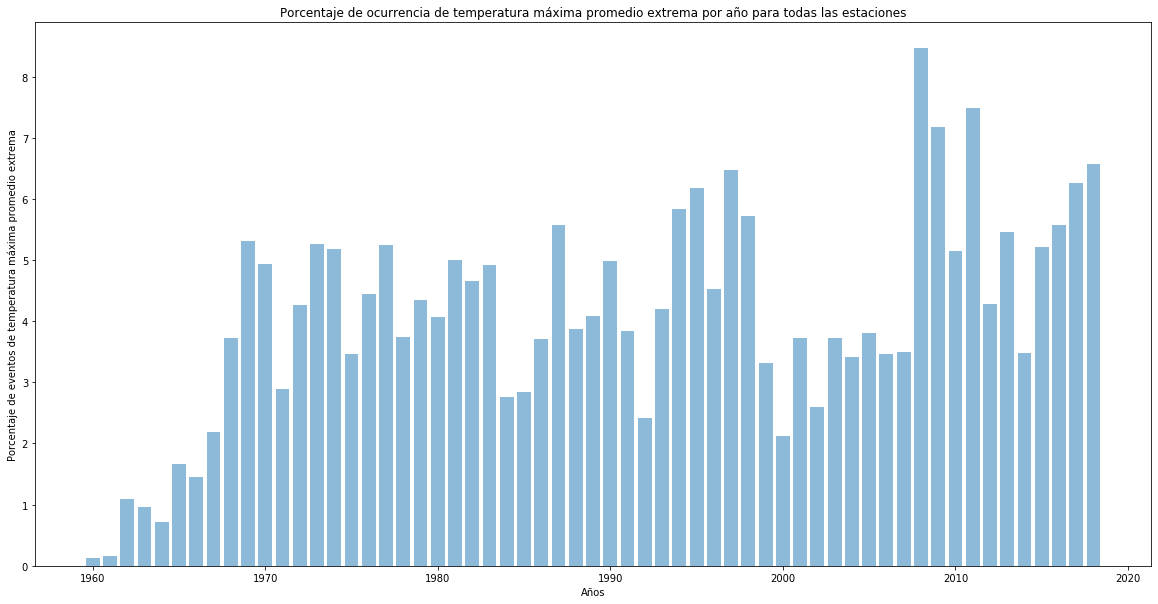

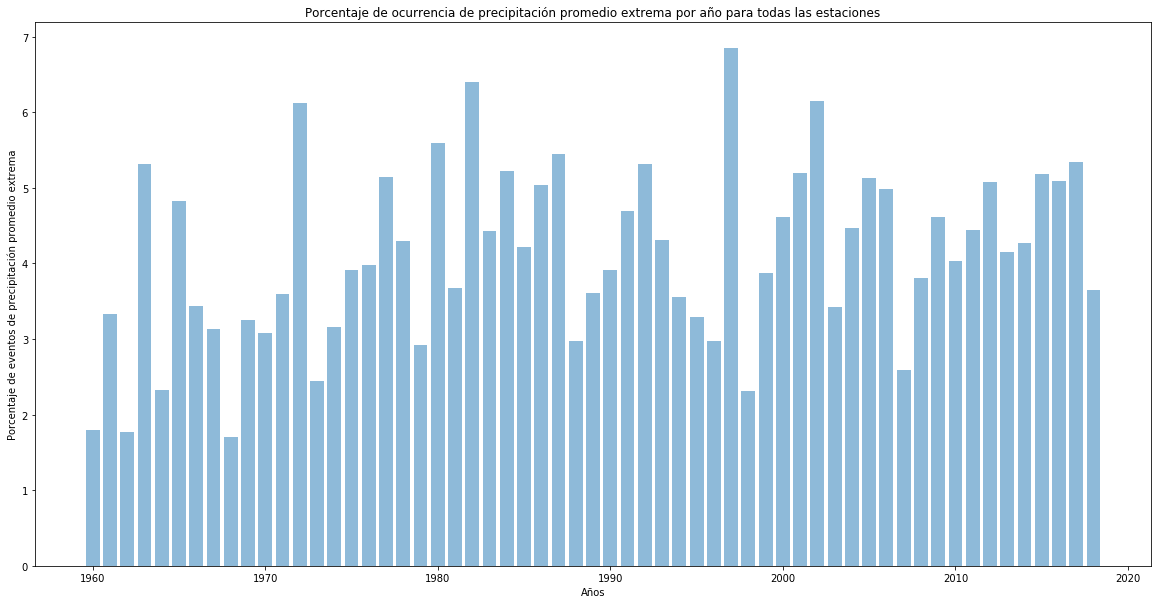

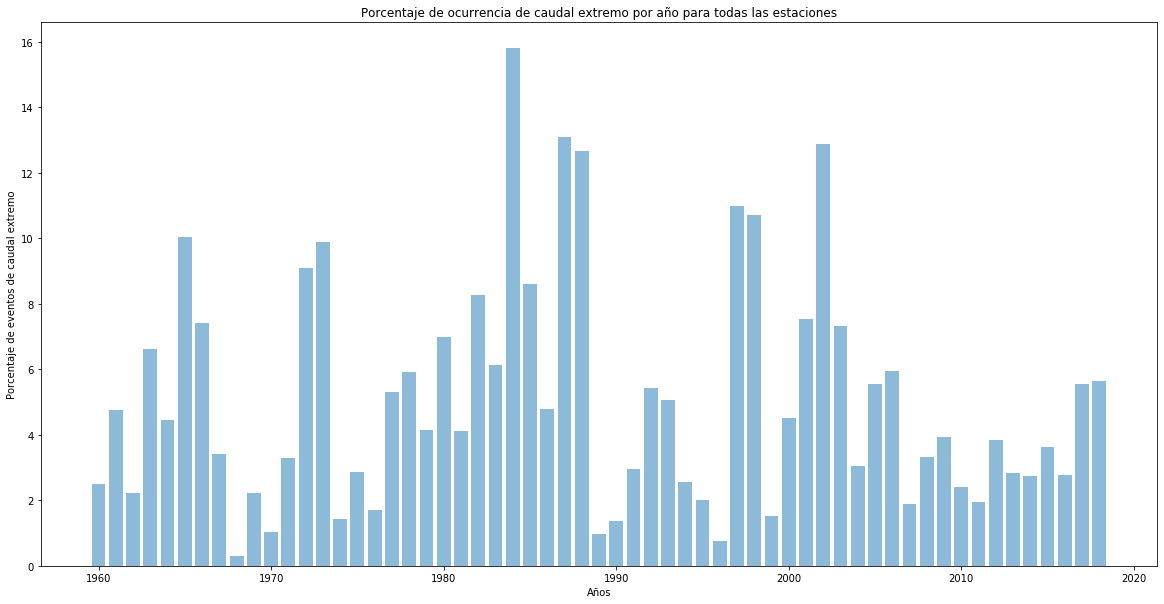

In [38]:
for var in ["extreme_temp_max_promedio", "extreme_precip_promedio", "extreme_caudal"]:
    plot_extreme_var_year(df_extreme_var, var, (20,10))

### plot por estación por año

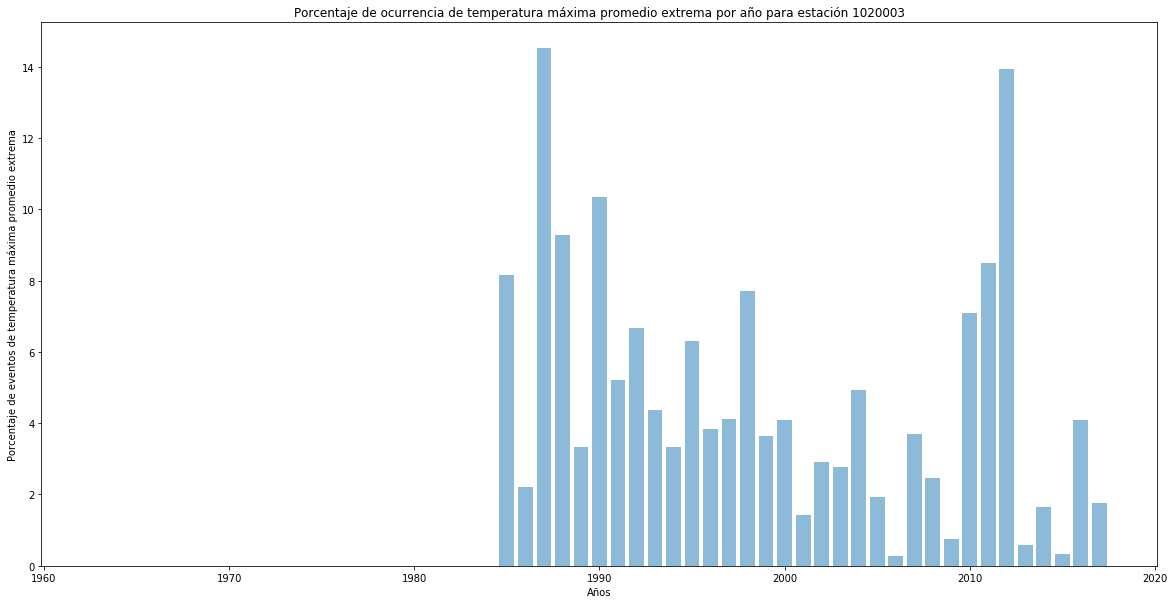

In [39]:
plot_extreme_var_year_per_station(df_extreme_var, "extreme_temp_max_promedio",1020003, (20,10))

## **7** Predicción Análisis de variable caudal extremo.

In [77]:
df_scaled_8394001 = df_scaled[df_scaled['codigo_estacion']==8394001]

In [59]:
df_scaled_8394001.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14806 entries, 642833 to 657638
Data columns (total 7 columns):
codigo_estacion      14806 non-null int64
codigo_cuenca        14806 non-null int64
fecha                14806 non-null object
caudal               14806 non-null float64
precip_promedio      14806 non-null float64
temp_max_promedio    14747 non-null float64
altura               14806 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 925.4+ KB


In [60]:
null_df_scaled_8394001 = df_scaled_8394001[df_scaled_8394001["temp_max_promedio"].isnull()]

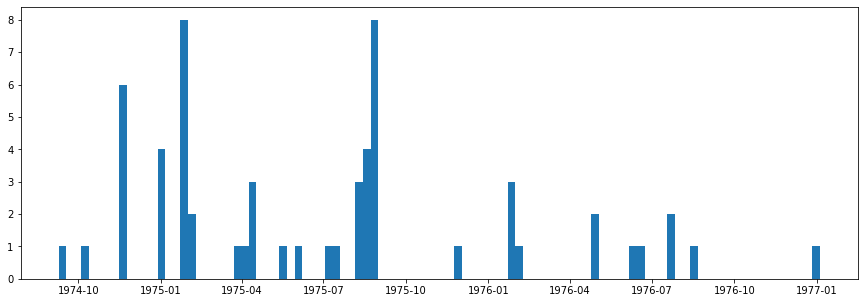

In [61]:
plt.figure(figsize=(15,5))
plt.hist(null_df_scaled_8394001["fecha"], bins=100);

In [78]:
df_scaled_8394001 = df_scaled_8394001[df_scaled_8394001['fecha'].apply(lambda x: x.year)>1980]

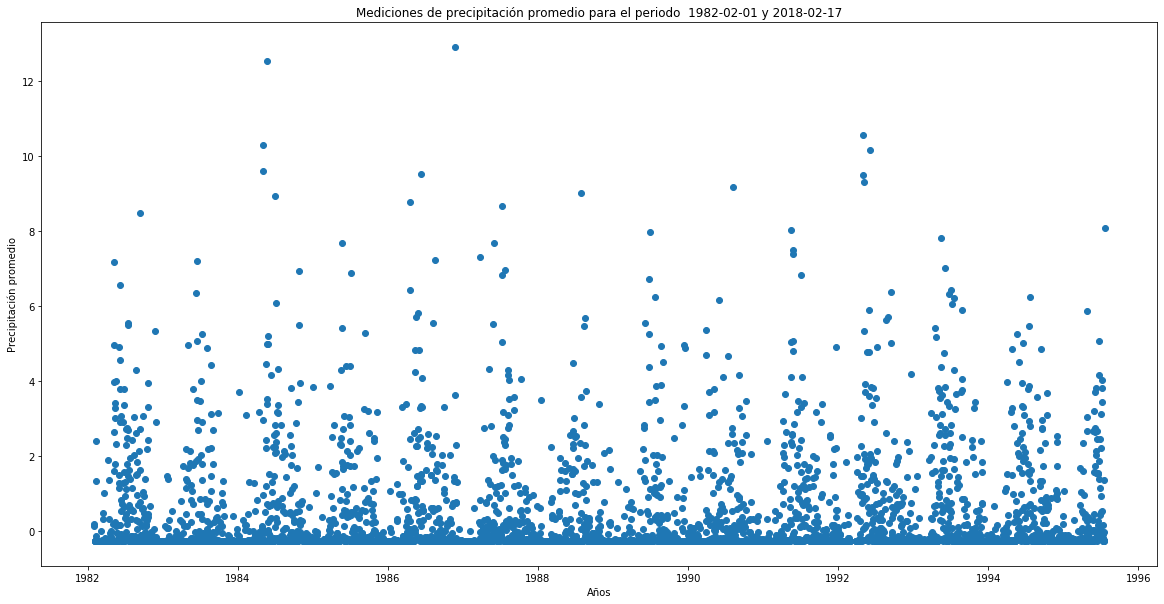

In [90]:
distribution_plot_station(df_scaled_8394001,8394001, "precip_promedio", "1982-01-06", "1995-07-22"  )

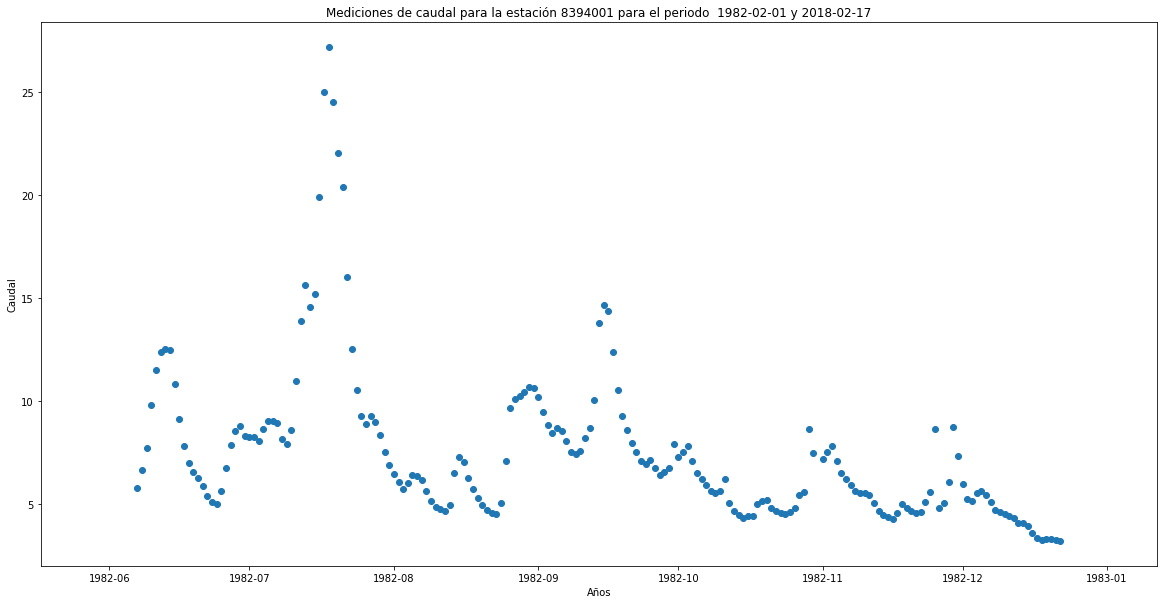

In [98]:
distribution_plot_station(df_scaled_8394001,8394001, "caudal", "1982-06-06", "1982-12-22"  )

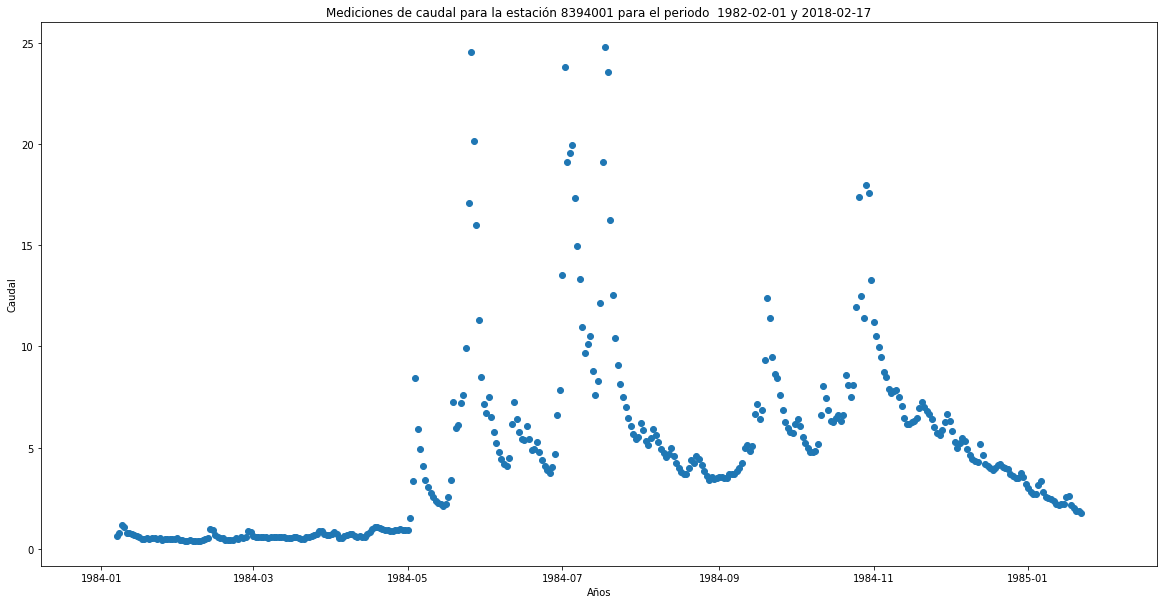

In [96]:
distribution_plot_station(df_scaled_8394001,8394001, "caudal", "1984-01-06", "1985-01-22"  )

In [164]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot


register_matplotlib_converters()

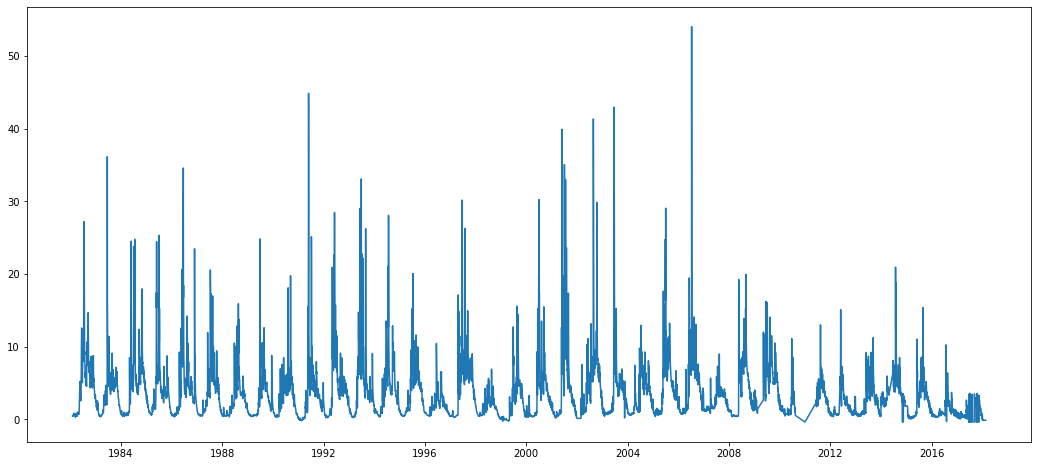

In [143]:
plt.plot( df_scaled_8394001_order['fecha'],df_scaled_8394001_order['caudal'])

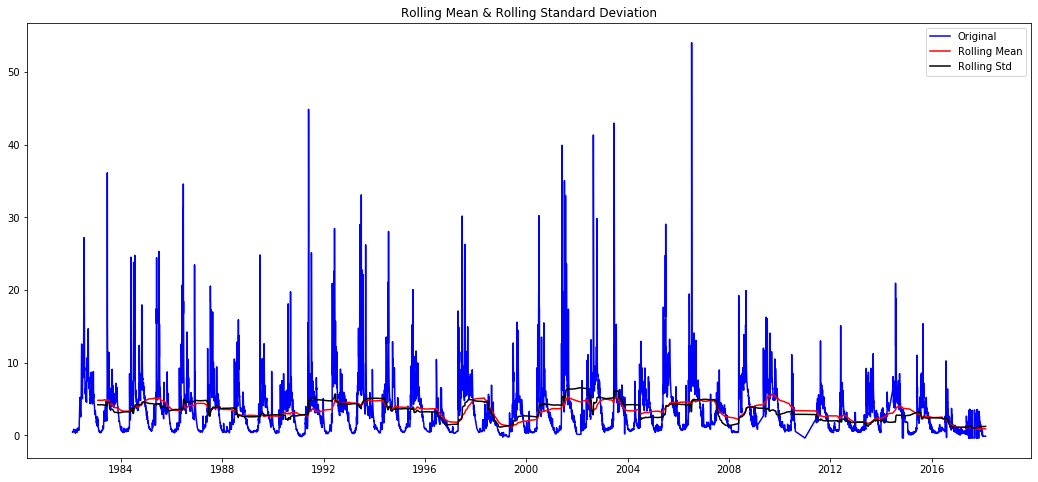

In [173]:
rolling_mean = df_arima.rolling(window = 365).mean()
rolling_std = df_arima.rolling(window=365).std()

plt.plot(df_arima, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

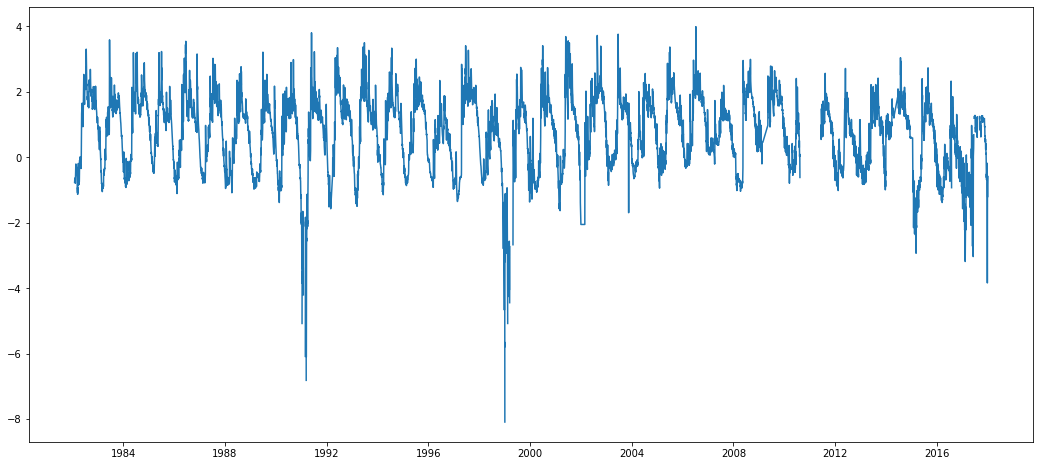

In [194]:
df_log = np.log(df_arima)
plt.plot(df_log)

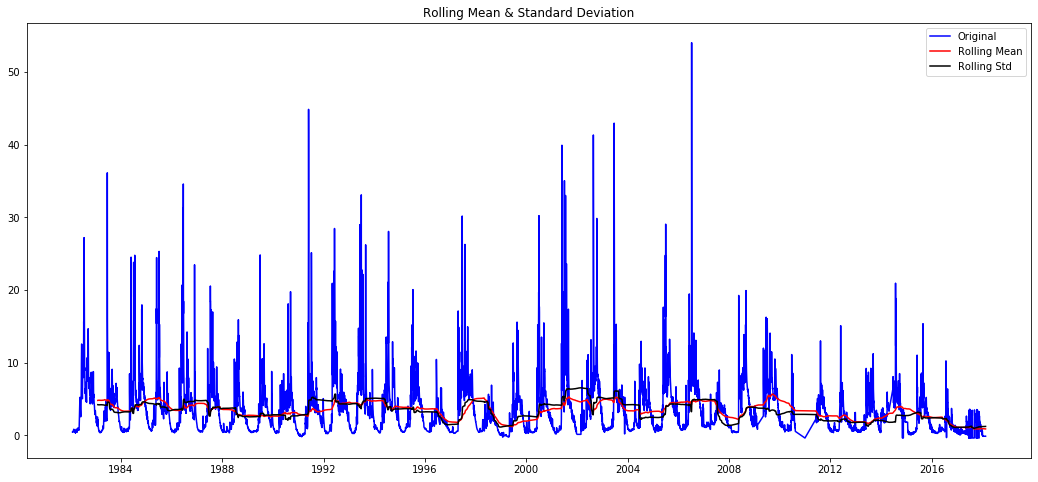

ADF Statistic: -8.86230651604016
p-value: 1.471634660001737e-14
Critical Values:
	1%: -3.430869510228873
	5%: -2.861769597819798
	10%: -2.5668922099375364


In [186]:
get_stationarity(df_arima)

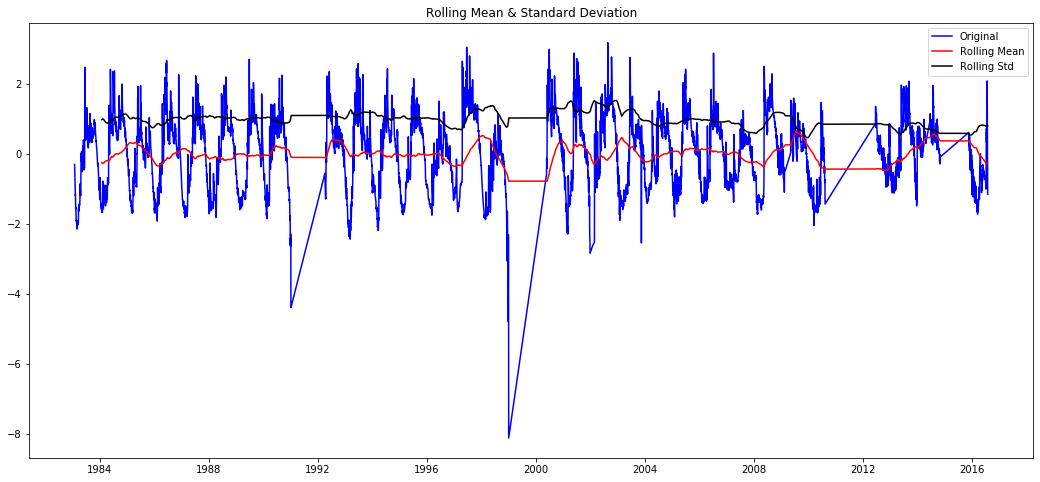

ADF Statistic: -8.009636266357221
p-value: 2.2192118162819106e-12
Critical Values:
	1%: -3.4310022711111827
	5%: -2.861828265119262
	10%: -2.566923438384092


In [190]:
rolling_mean = df_log.rolling(window=365).mean()
df_log_minus_mean = df_log - rolling_mean
df_log.dropna(inplace=True)
get_stationarity(df_log)

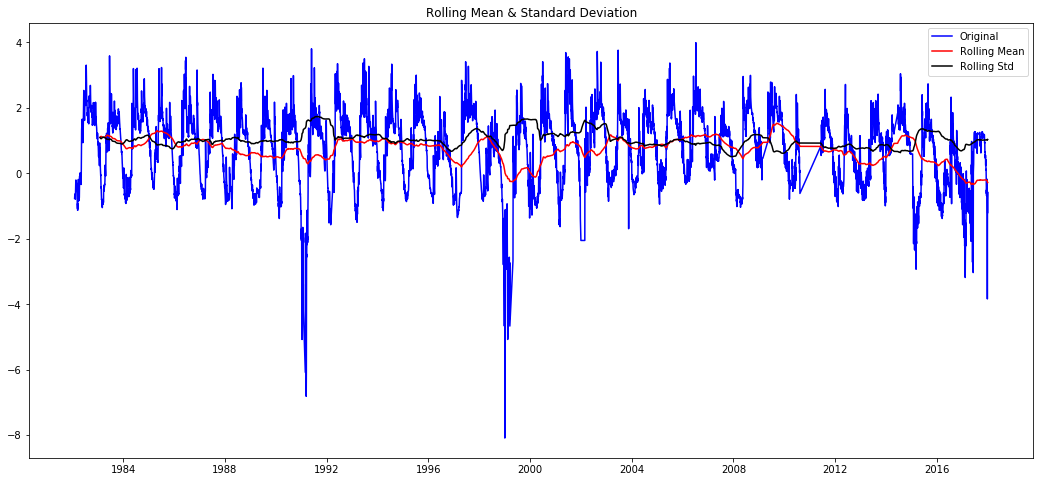

ADF Statistic: -9.027170408992886
p-value: 5.5696802646832985e-15
Critical Values:
	1%: -3.4308794794285387
	5%: -2.861774003320096
	10%: -2.5668945549578366


In [191]:
df_log.dropna(inplace=True)
get_stationarity(df_log)

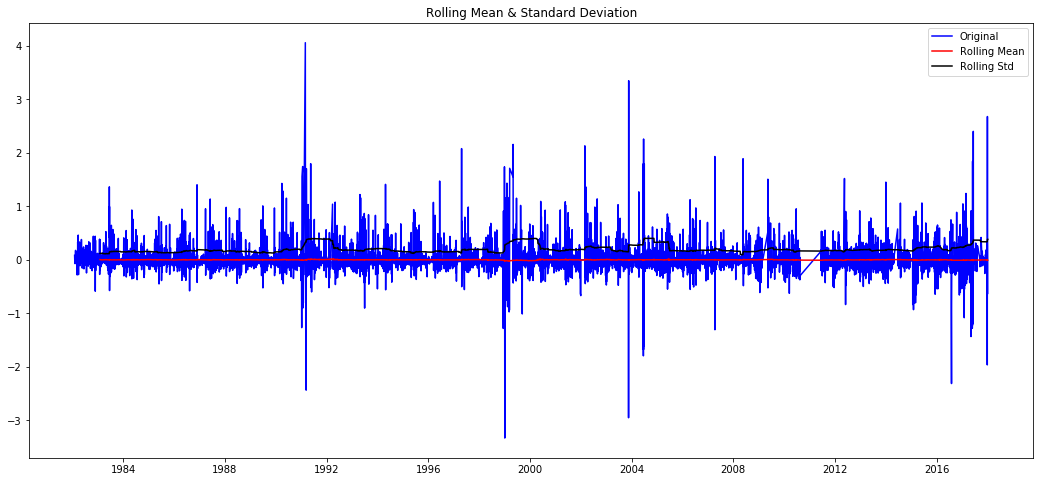

ADF Statistic: -16.38977095839124
p-value: 2.701198233540109e-29
Critical Values:
	1%: -3.430880553385666
	5%: -2.8617744779128222
	10%: -2.566894807580734


In [195]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [142]:
df_scaled_8394001_order =df_scaled_8394001.sort_values(by='fecha')

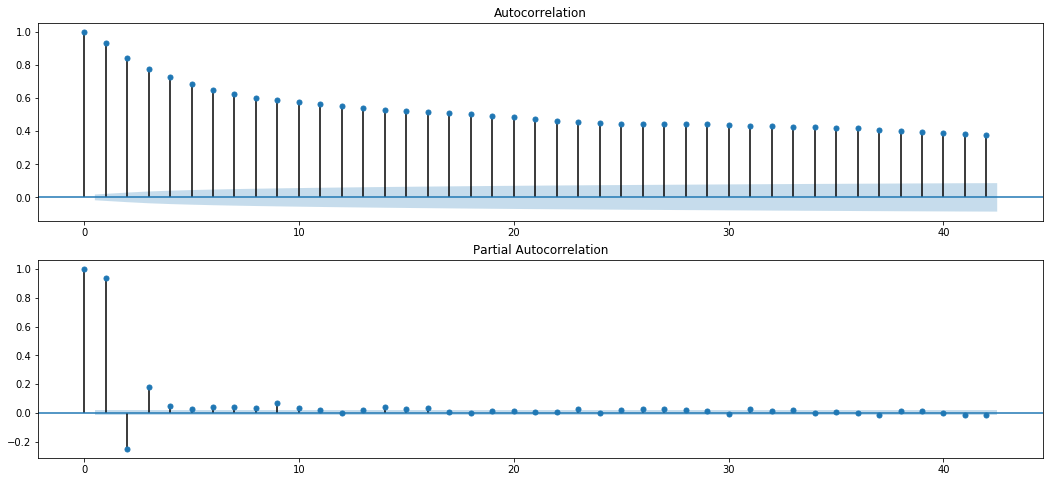

In [167]:

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_arima, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(df_arima, ax=pyplot.gca())
pyplot.show()

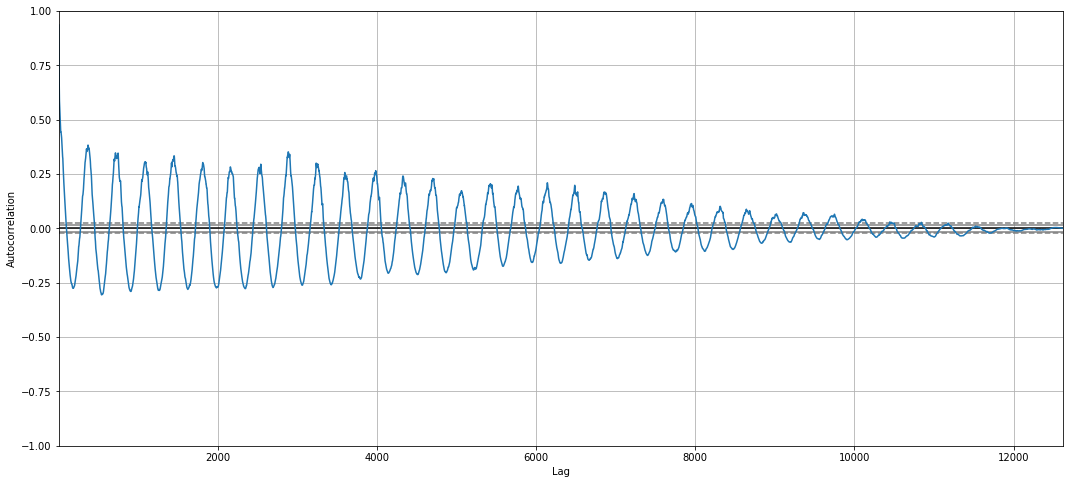

In [170]:
autocorrelation_plot(df_arima)


/Users/nisum/.local/share/virtualenvs/ml-KN9xk5_2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


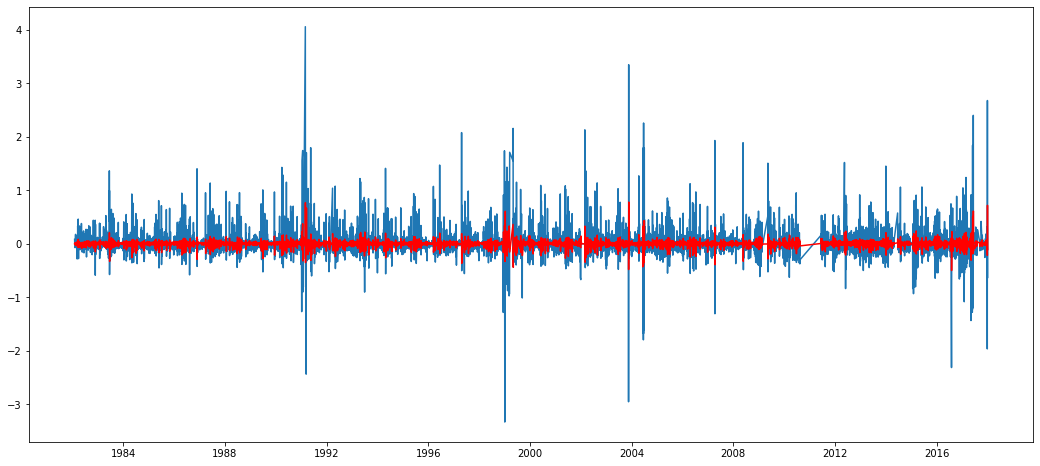

In [219]:
decomposition = seasonal_decompose(df_log_shift, freq = 365)
model = ARIMA(df_log_shift, order=(2,0,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color="red")
             

/Users/nisum/.local/share/virtualenvs/ml-KN9xk5_2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


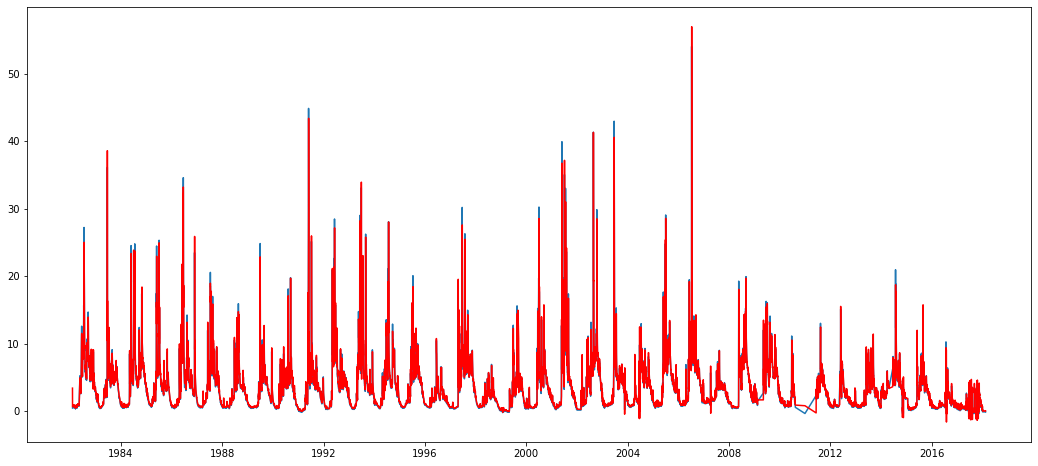

In [225]:
decomposition = seasonal_decompose(df_arima, freq = 365)
model = ARIMA(df_arima, order=(2,0,2))
results = model.fit(disp=-1)
plt.plot(df_arima)
plt.plot(results.fittedvalues, color="red")
             

In [237]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
X = df_arima['caudal'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

KeyboardInterrupt: 